<h1 align="center" style="font-size: 3em;">RL Assignment 2024-25</h1>


# 1) Selected Environment: **MountainCarContinuous-v0**

### **1. Environment Description**
The **MountainCarContinuous-v0** environment models a deterministic Markov Decision Process (MDP) in which an underpowered car must navigate a sinusoidal valley to reach the goal position on the right hilltop by strategically applying accelerations. This continuous version allows the agent to apply forces in a range, unlike the discrete action version.

---

### **2. Action Space**
- **Type**: `Box(-1.0, 1.0, (1,), float32)`
- **Description**:
  - The action is a **continuous scalar** representing the directional force applied to the car.
  - Range:
    - **-1.0**: Maximum force to the left.
    - **1.0**: Maximum force to the right.
  - The applied force is scaled by a constant power of `0.0015`.

---

### **3. Observation Space**
- **Type**: `Box([-1.2, -0.07], [0.6, 0.07], (2,), float32)`
- **Shape**: `(2,)`
- **Description**:
  The observation is a 2-dimensional array with the following elements:
  1. **Position** (`x`): 
     - Range: `[-1.2, 0.6]` meters.
     - Represents the car's horizontal position along the x-axis.
  2. **Velocity** (`v`): 
     - Range: `[-0.07, 0.07]` meters per timestep.
     - Represents the car's velocity.

  Both position and velocity are clipped to their respective ranges.

---

### **4. Transition Dynamics**
The environment follows the equations:

- **Velocity Update**:

  $
  \text{velocity}_{t+1} = \text{velocity}_t + (\text{action} \cdot \text{power}) - 0.0025 \cdot \cos(3 \cdot \text{position}_t)
  $

- **Position Update**:

  $
  \text{position}_{t+1} = \text{position}_t + \text{velocity}_{t+1}
  $

- **Key Dynamics**:
  - `action` is clipped to `[-1, 1]`.
  - **Collisions**:
    - At the left bound (`-1.2`) or right bound (`0.6`), velocity is set to `0`.
  - Power constant: `0.0015`.

---

### **5. Reward Signal**
- **Reward Formula**:

  $
  \text{reward} = -0.1 \cdot (\text{action}^2) + 100 \cdot \mathbb{1}(\text{position} \geq 0.45)
  $

---

### **6. Starting State**
- **Initial Position**:
  - Uniformly sampled from the range `[-0.6, -0.4]`.
- **Initial Velocity**:
  - Always starts at `0`.

---

### **7. Episode Termination**
The episode ends when:
1. **Termination**:
   - The car’s position reaches or exceeds `0.45` (goal position on the right hill).
2. **Truncation**:
   - The maximum number of timesteps (999) is reached.

---

### **8. Challenges**
- The car does not have enough power to climb directly to the goal, so the agent must learn to **leverage momentum** effectively by oscillating between the hills.
- The environment’s reward structure encourages both goal achievement and energy efficiency.

---

### **9. Implementation**
#### **Initialization**
```python
import gymnasium as gym
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array", goal_velocity=0.1)
```

#### **Reset the Environment**
```python
state, _ = env.reset(seed=123, options={"low": -0.7, "high": -0.5})  # Default low=-0.6, high=-0.4
```

#### **Sample Actions**
```python
action = env.action_space.sample()  # Continuous action in [-1.0, 1.0]
```

#### **Step Through the Environment**
```python
next_state, reward, done, truncated, info = env.step(action)
```

---

### **10. Analysis**
1. **Action Space**:
   - The continuous nature of the action space allows for fine control, making it more challenging to optimize compared to the discrete version.

2. **Reward Signal**:
   - The combination of negative action penalties and goal rewards balances energy efficiency and task completion.

3. **Exploration Challenges**:
   - Sparse rewards (only achieved at the goal) require effective exploration strategies such as **noise-based exploration** or **entropy regularization**.

4. **Algorithm Recommendations**:
   - **Policy Gradient Methods**:
     - Suitable for continuous action spaces, e.g., **REINFORCE**, **PPO**, **DDPG**, or **SAC**.
   - **Value-Based Methods**:
     - Adaptations like **DDPG** or **TD3** can handle continuous action spaces.

---

# 2) **DQN IMPLEMENTATION**

## 1. **Imports and Setup**

In [22]:
import os
import time
import torch
import pygame
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Description
This section imports essential libraries and performs initial setup for the Reinforcement Learning (RL) implementation:

- **Torch:** For building and training deep learning models with GPU acceleration.
- **Gymnasium:** For simulating and interacting with RL environments.
- **Matplotlib:** For visualizing training progress and reward trends.
- **Numpy:** For efficient numerical computations.
- **Pygame:** For rendering the environment and visualizing interactions.
- **OS:** Provides utilities for managing file paths and system resources.
- **Device Setup:** Configures the use of GPU (if available) for faster training or defaults to the CPU.

These libraries provide the core functionality for implementing, training, and visualizing the RL agent within the chosen environment.

## 2. **Seeding**

In [23]:
def set_seed(seed=0):
    """
    Set seed for reproducibility across multiple libraries and environments.

    Args:
        seed (int): The seed value to set. Default is 0.
    """
    # Seed NumPy
    np.random.seed(seed)
    np.random.default_rng(seed)
    
    # Seed Python's built-in hash function
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Seed PyTorch on CPU
    torch.manual_seed(seed)
    
    # Seed PyTorch on GPU if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True  # Ensure deterministic results

The `set_seed` function ensures reproducibility by setting a consistent seed for random number generation across:

- **NumPy**: Seeds random number generation for consistent results.
- **Python**: Sets `PYTHONHASHSEED` for deterministic hashing.
- **PyTorch**: Seeds both CPU and GPU (if available) for consistent model behavior.
- **Deterministic GPU Operations**: Configures cuDNN for deterministic results.

## 3. **Replay Memory**

In [24]:
class ReplayMemory:
    """
    Replay memory using pre-allocated NumPy arrays for efficiency.
    """

    def __init__(self, capacity, state_dim, action_dim, device):
        """
        Initialize the ReplayMemory with fixed-size arrays.

        Args:
            capacity (int): Maximum number of transitions to store.
            state_dim (int or tuple): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            device (torch.device): Device to which the sampled tensors should be moved.
        """
        self.capacity = capacity
        self.device = device
        self.current_idx = 0
        self.is_full = False

        # Pre-allocate memory for transitions
        self.states = np.zeros((capacity, *state_dim), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.int64)
        self.next_states = np.zeros((capacity, *state_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity,), dtype=np.float32)
        self.terminateds = np.zeros((capacity,), dtype=bool) 

    def store(self, state, action, next_state, reward, terminated):
        """
        Store a transition in the replay memory.

        Args:
            state (np.ndarray): Current state.
            action (int or float): Action taken.
            next_state (np.ndarray): Next state after the action.
            reward (float): Reward received.
            terminated (bool): Whether the episode terminated (natural end).
        """
        self.states[self.current_idx] = state
        self.actions[self.current_idx] = action
        self.next_states[self.current_idx] = next_state
        self.rewards[self.current_idx] = reward
        self.terminateds[self.current_idx] = terminated  

        # Update the index and handle buffer wrapping
        self.current_idx += 1
        if self.current_idx == self.capacity:
            self.is_full = True
            self.current_idx = 0

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions.

        Args:
            batch_size (int): Number of transitions to sample.

        Returns:
            Tuple[torch.Tensor]: Sampled transitions (states, actions, next_states, rewards, terminateds).
        """
        upper_bound = self.capacity if self.is_full else self.current_idx
        indices = np.random.choice(upper_bound, size=batch_size, replace=False)

        # Convert sampled data to PyTorch tensors and move to the device
        states = torch.as_tensor(self.states[indices], device=self.device)
        actions = torch.as_tensor(self.actions[indices], device=self.device)
        next_states = torch.as_tensor(self.next_states[indices], device=self.device)
        rewards = torch.as_tensor(self.rewards[indices], device=self.device)
        terminateds = torch.as_tensor(self.terminateds[indices], device=self.device)

        return states, actions, next_states, rewards, terminateds

    def __len__(self):
        """
        Return the current number of stored transitions.

        Returns:
            int: Number of stored transitions.
        """
        return self.capacity if self.is_full else self.current_idx


### **Class: `ReplayMemory`**

Replay memory for storing and sampling transitions to train the Deep Q-Network (DQN) agent.

#### **Attributes**:
- `capacity` (int): Maximum number of transitions.
- `device` (torch.device): Device for storing sampled tensors.
- `states` (np.ndarray): Stores states of the environment.
- `actions` (np.ndarray): Stores actions taken.
- `next_states` (np.ndarray): Stores resulting states after actions.
- `rewards` (np.ndarray): Stores rewards received.
- `terminateds` (np.ndarray): Tracks whether episodes have terminated.

#### **Methods**:
1. **`__init__(capacity, state_dim, action_dim, device)`**:
   Initializes fixed-size arrays for transitions.

2. **`store(state, action, next_state, reward, terminated)`**:
   Saves a transition to memory and handles index updates.

3. **`sample(batch_size)`**:
   Randomly samples a batch of transitions and converts them into PyTorch tensors.

4. **`__len__()`**:
   Returns the number of stored transitions.

#### **Usage in DQN**:
Replay memory plays an important role in DQN by:
- **Breaking correlation**: Ensures that samples used for training are uncorrelated by shuffling past experiences.
- **Efficient sampling**: Allows mini-batch training by sampling fixed-size batches from stored transitions.
- **Stabilizing learning**: Helps prevent the agent from forgetting past knowledge by retaining experiences over time.


## 4. **Deep Q-Network (DQN)**

In [25]:
class DQN_Network(nn.Module):
    """
    The Deep Q-Network (DQN) model for reinforcement learning.
    
    This network approximates the Q-value function, which predicts the expected 
    cumulative reward for each possible action in a given state. The architecture 
    consists of fully connected (FC) layers with ReLU activation functions.
    """

    def __init__(self, num_actions, input_dim, hidden_dim=64):
        """
        Initialize the DQN network.

        Args:
            num_actions (int): The number of possible actions in the environment. 
                               This determines the size of the output layer.
            input_dim (int): The dimensionality of the input state space, i.e., the 
                             number of features describing the state.
            hidden_dim (int, optional): The number of units in the hidden layer. 
                                        Default is 64.
        """
        super(DQN_Network, self).__init__()
        
        # Define the fully connected layers of the network
        self.FC = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Input to hidden layer
            nn.ReLU(inplace=True),            # Activation function
            nn.Linear(hidden_dim, num_actions)  # Hidden to output layer
        )
        
        # Apply Xavier Initialization to all Linear layers
        self.FC.apply(self.init_weights)

    def init_weights(self, layer):
        """
        Initialize weights for Linear layers using Xavier Uniform initialization.
        
        Xavier initialization ensures that the variance of the activations remains 
        consistent across layers, preventing vanishing or exploding gradients. 
        This is particularly effective for activation functions like ReLU.
        
        Args:
            layer (nn.Module): A layer in the neural network. If it is a Linear 
                               layer, its weights and biases are initialized.
        """
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)  # Initialize weights
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)  # Initialize biases to zero

    def forward(self, x):
        """
        Perform the forward pass to compute Q-values for each action.

        The forward pass processes the input state through the fully connected 
        layers, applying the ReLU activation in the hidden layer, and outputs 
        the Q-values for all possible actions.

        Args:
            x (torch.Tensor): A tensor representing the state of the environment. 
                              Shape: (batch_size, input_dim).

        Returns:
            torch.Tensor: A tensor containing Q-values for each action. 
                          Shape: (batch_size, num_actions).
        """
        return self.FC(x)

### **DQN Network Architecture**

A neural network designed to approximate Q-values, predicting cumulative rewards for each action given the current state.

#### **Attributes**:
1. **`num_actions`** *(int)*:
   - Number of possible actions in the environment.
   - Determines the size of the output layer.

2. **`input_dim`** *(int)*:
   - Dimensionality of the input state space.
   - Represents the features describing the current state.

3. **`hidden_dim`** *(int, optional)*:
   - Number of units in the hidden layer (default: 64).
   - Controls the network's capacity for learning complex representations.

#### **Methods**:
1. **`__init__(num_actions, input_dim, hidden_dim)`**:
   - Initializes a fully connected network with:
     - An input layer mapping the state space to hidden representations.
     - A hidden layer with ReLU activation.
     - An output layer producing Q-values for all actions.
   - Xavier initialization is applied to all linear layers for stable training.

2. **`init_weights(layer)`**:
   - Applies **Xavier Uniform Initialization** to linear layers:
     - Ensures consistent variance across layers.
     - Reduces the likelihood of vanishing or exploding gradients.
   - Bias terms are initialized to zero for simplicity and symmetry.

3. **`forward(x)`**:
   - Processes input states through the network to compute Q-values.
   - **Input**:
     - `x` *(torch.Tensor)*: A batch of states with shape `(batch_size, input_dim)`.
   - **Output**:
     - Tensor of Q-values for each action, shape `(batch_size, num_actions)`.

#### **Usage in DQN**:
The network learns to approximate the Q-value function during training by:
- Minimizing the error between predicted and target Q-values.
- Enabling the agent to select optimal actions using the **greedy policy**.


## 5. **DQN Agent**

In [26]:
class DQN_Agent:
    """
    DQN Agent for reinforcement learning.
    
    This class implements the core components of the Deep Q-Network (DQN) algorithm, 
    including epsilon-greedy action selection, learning updates, target network synchronization, 
    and experience replay.
    """

    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay, clip_grad_norm, 
                 learning_rate, discount, memory_capacity, seed, network_class=DQN_Network, hidden_dim=64):
        """
        Initialize the DQN agent.

        Args:
            env (gym.Env): The environment in which the agent operates.
            epsilon_max (float): Initial value of epsilon for the epsilon-greedy policy.
            epsilon_min (float): Minimum value of epsilon for the epsilon-greedy policy.
            epsilon_decay (float): Decay rate for epsilon.
            clip_grad_norm (float): Maximum value for gradient clipping to prevent exploding gradients.
            learning_rate (float): Learning rate for the optimizer.
            discount (float): Discount factor for future rewards (gamma).
            memory_capacity (int): Capacity of the replay memory buffer.
        """
        self.loss_history = []  # Tracks the loss per episode
        self.running_loss = 0   # Accumulates loss during an episode
        self.learned_counts = 0  # Tracks the number of updates per episode

        # Reinforcement learning hyperparameters
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount = discount

        self.action_space = env.action_space
        self.action_space.seed(seed)  # Set the seed for reproducible action sampling
        self.observation_space = env.observation_space
        self.replay_memory = ReplayMemory(memory_capacity, self.observation_space.shape, 1, device)

        # Initialize the main and target networks
        input_dim = self.observation_space.shape[0]
        output_dim = self.action_space.n
        self.main_network = network_class(num_actions=output_dim, input_dim=input_dim, hidden_dim=hidden_dim).to(device)
        self.target_network = network_class(num_actions=output_dim, input_dim=input_dim, hidden_dim=hidden_dim).to(device).eval()
        self.target_network.load_state_dict(self.main_network.state_dict())

        # Loss function and optimizer
        self.clip_grad_norm = clip_grad_norm
        self.criterion = torch.nn.MSELoss()
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)

    def select_action(self, state):
        """
        Select an action based on the epsilon-greedy policy.

        Args:
            state (torch.Tensor): Input tensor representing the current state.

        Returns:
            int: The selected action.
        """
        # Exploration: Select a random action
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()

        # Exploitation: Select the action with the highest Q-value
        if not torch.is_tensor(state):  # Ensure the state is a tensor
            state = torch.as_tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            Q_values = self.main_network(state)
            action = torch.argmax(Q_values).item()
        return action

    def learn(self, batch_size, done):
        """
        Perform a learning step to update the main network's parameters.

        Args:
            batch_size (int): Number of samples to draw from the replay memory.
            done (bool): Whether the current episode is finished. Used for logging purposes.
        """
        # Sample a batch of transitions from the replay memory
        states, actions, next_states, rewards, terminateds = self.replay_memory.sample(batch_size)

        rewards = rewards.unsqueeze(1)
        terminateds = terminateds.unsqueeze(1)

        # Compute Q-values for the selected actions
        predicted_q = self.main_network(states).gather(dim=1, index=actions)

        # Compute the target Q-values using the target network
        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
            next_target_q_value[terminateds] = 0  # No future rewards for terminal states

        # Bellman equation for target Q-values
        y_js = rewards + (self.discount * next_target_q_value)

        # Compute the loss
        loss = self.criterion(predicted_q, y_js)

        # Update running loss and log loss at the end of the episode
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss = 0
            self.learned_counts = 0

        # Optimize the main network
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        self.optimizer.step()

    def update_target_network(self):
        """
        Update the target network by copying parameters from the main network.

        This is a "hard" update, where the target network parameters are directly 
        replaced with the main network's parameters.
        """
        self.target_network.load_state_dict(self.main_network.state_dict())

    def update_epsilon(self):
        """
        Update epsilon for the epsilon-greedy exploration strategy.

        The value of epsilon decreases over time, reducing exploration and increasing exploitation.
        """
        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)

    def save_checkpoint(self, path):
        """
        Save the main network's parameters and training metadata to a checkpoint file.

        Args:
            path (str): Path to the file where the checkpoint will be saved.
        """
        checkpoint = {
            "main_network_state_dict": self.main_network.state_dict(),  # Model weights
            "optimizer_state_dict": self.optimizer.state_dict(),        # Optimizer state
            "loss_history": self.loss_history,                           # Loss history for logging
            "learning_rate": self.optimizer.defaults['lr'],             # Current learning rate
        }
        torch.save(checkpoint, path)


### **DQN Agent**
This class represents the Deep Q-Network (DQN) agent.

#### **Key Attributes**:
- `env`: Environment in which the agent operates.
- `epsilon_max`, `epsilon_min`, `epsilon_decay`: Parameters for controlling exploration.
- `clip_grad_norm`: Maximum gradient norm for clipping.
- `learning_rate`, `discount`: Learning hyperparameters.
- `replay_memory`: Stores and samples past transitions.
- `main_network`: Q-network for approximating Q-values.
- `target_network`: Target Q-network for stable learning.

#### **Methods**:
1. **`__init__(...)`**:
   Initializes the agent, networks, and hyperparameters.

2. **`select_action(state)`**:
   Implements epsilon-greedy action selection.

3. **`learn(batch_size, done)`**:
   Performs a learning update using a batch of transitions.

4. **`update_target_network()`**:
   Synchronizes the target network with the main network.

5. **`update_epsilon()`**:
   Adjusts the exploration rate over time.

6. **`save_checkpoint(path)`**:
   Saves the network's parameters and training state to a file.

#### **Usage in DQN**:
The DQN agent implements the core components of the DQN algorithm:
- Epsilon-greedy policy for balancing exploration and exploitation.
- Learning updates using experience replay.
- Synchronization of the target network for stability.
- Gradient clipping to mitigate exploding gradients.


## 6. **Environment Wrappers**

In [36]:
class step_wrapper(gym.Wrapper):
    """
    A wrapper for customizing the behavior of an environment's step and reset methods.

    This wrapper applies modifications to the state and reward functions returned by 
    the `step` and `reset` methods using the `observation_wrapper` and `reward_wrapper`.

    Args:
        env (gym.Env): The environment to be wrapped.
    """
    def __init__(self, env, reward_function=reward_wrapper):
        """
        Initialize the step wrapper with the environment to be wrapped.

        Args:
            env (gym.Env): The environment to be wrapped.
        """
        super().__init__(env)
        self.observation_wrapper = observation_wrapper(env)
        self.reward_wrapper = reward_function(env)

    def step(self, action):
        """
        Execute a step in the environment with a modified state and reward.

        Args:
            action (int): The action to be taken.

        Returns:
            Tuple: Modified state, modified reward, done flag, truncation flag, and info.
        """
        state, reward, done, truncation, info = self.env.step(action)
        modified_state = self.observation_wrapper.observation(state)
        modified_reward = self.reward_wrapper.reward(modified_state, action)
        return modified_state, modified_reward, done, truncation, info

    def reset(self, seed=None):
        """
        Reset the environment and return the modified initial state.

        Args:
            seed (int, optional): Random seed for the environment reset.

        Returns:
            Tuple: Modified initial state and additional info.
        """
        state, info = self.env.reset(seed=seed)
        modified_state = self.observation_wrapper.observation(state)
        return modified_state, info


class observation_wrapper(gym.ObservationWrapper):
    """
    A wrapper for modifying observations in the environment.

    This wrapper normalizes observations using min-max scaling for improved compatibility
    with neural network inputs.

    Args:
        env (gym.Env): The environment to wrap.
    """
    def __init__(self, env):
        """
        Initialize the observation wrapper.

        Args:
            env (gym.Env): The environment to wrap.
        """
        super().__init__(env)
        self.min_value = env.observation_space.low
        self.max_value = env.observation_space.high

    def observation(self, state):
        """
        Normalize the observation using min-max scaling.

        Args:
            state (numpy.ndarray): The original observation from the environment.

        Returns:
            numpy.ndarray: The normalized observation.
        """
        return (state - self.min_value) / (self.max_value - self.min_value)


class reward_wrapper(gym.RewardWrapper):
    """
    A wrapper for customizing rewards in the environment.

    This wrapper penalizes large actions and provides a bonus for achieving the goal.

    Args:
        env (gym.Env): The environment to wrap.
    """
    def __init__(self, env):
        """
        Initialize the reward wrapper.

        Args:
            env (gym.Env): The environment to wrap.
        """
        super().__init__(env)

    def reward(self, state, action):
        """
        Compute a modified reward based on the current state and action.

        - Applies a penalty proportional to the square of the action magnitude.
        - Rewards the agent with a bonus for reaching the goal.

        Args:
            state (numpy.ndarray): The state of the environment.
            action (int): The action taken.

        Returns:
            float: The modified reward.
        """
        position, velocity = state
        continuous_action = self.env.discrete_actions[action]

        if position >= 0.9167:  # Goal position
            return 100.0 - 0.1 * (continuous_action ** 2)  # Goal reward with penalty

        return -0.1 * (continuous_action ** 2)  # Regular penalty


class DiscretizedActionWrapper(gym.ActionWrapper):
    """
    A wrapper to discretize the continuous action space of the environment.

    Converts the continuous action space into a finite number of bins for environments
    like `MountainCarContinuous-v0`.

    Args:
        env (gym.Env): The environment to wrap.
        num_bins (int, optional): Number of discrete bins. Default is 20.
    """
    def __init__(self, env, num_bins=20):
        """
        Initialize the action wrapper.

        Args:
            env (gym.Env): The environment to wrap.
            num_bins (int, optional): Number of discrete bins. Default is 20.
        """
        super().__init__(env)
        self.num_bins = num_bins
        self.action_space = gym.spaces.Discrete(num_bins)
        self.discrete_actions = np.linspace(env.action_space.low[0], env.action_space.high[0], num_bins)

    def action(self, action):
        """
        Map a discrete action to its corresponding continuous value.

        Args:
            action (int): The discrete action index.

        Returns:
            list: The corresponding continuous action value.
        """
        return [self.discrete_actions[action]]


### **Custom Gym Wrappers**
These custom wrappers modify and extend the behavior of Gym environments for better control and performance.

---

#### **1. `step_wrapper`**
A wrapper to modify the behavior of the `step` and `reset` methods in the environment.

- **Purpose**: 
  - Adjusts states and rewards using additional wrappers.
- **Key Methods**:
  - `step(action)`: Executes an action, returning the modified state and reward.
  - `reset(seed=None)`: Resets the environment and returns the modified initial state.

---

#### **2. `observation_wrapper`**
A wrapper to normalize observations in the environment.

- **Purpose**: 
  - Scales observations to a `[0, 1]` range using min-max normalization.
- **Key Method**:
  - `observation(state)`: Normalizes the given state for compatibility with neural network inputs.

---

#### **3. `reward_wrapper`**
A wrapper to customize the reward function of the environment.

- **Purpose**: 
  - Penalizes large actions and adds bonuses for achieving goals.
- **Key Method**:
  - `reward(state, action)`: Modifies the reward based on the agent's state and actions.
  - **Note**: The goal position is normalized. The raw goal position $0.45$ in the range $[-1.2, 0.6]$ is scaled to:

    $
    \text{normalized goal position} = \frac{0.45 - (-1.2)}{0.6 - (-1.2)} \approx 0.9167
    $

    This normalized value is used in the reward computation.

---

#### **4. `DiscretizedActionWrapper`**
A wrapper to discretize the continuous action space of the environment.

- **Purpose**:
  - Converts the continuous action space (e.g., `[-1, 1]`) into a finite number of discrete bins for simplified decision-making by the agent.

- **How it Works**:
  - The continuous action range, typically `[-1, 1]`, is divided into `num_bins` equally spaced values.
  - Each discrete action corresponds to one of these bins, allowing the agent to choose from a fixed set of possible actions.

- **Key Parameters**:
  - `num_bins`: Determines the granularity of the discretization. More bins provide finer control over actions, but increase complexity.
  - `action_space`: Defined as a discrete space with size equal to `num_bins`.

- **Key Methods**:
  - `action(action)`: Maps a discrete action index to the corresponding continuous value.
    - The mapping uses the equation:
      $
      \text{discrete\_action}[i] = \text{low} + i \cdot \frac{\text{high} - \text{low}}{\text{num\_bins} - 1}
      $
      where `low = -1` and `high = 1`.



## 7. **DQN Training and Testing**

In [37]:
class DQN_Train:
    """
    A class to train and test a Deep Q-Network (DQN) agent on a given environment.

    This class manages the training and testing process of a reinforcement learning agent, including:
    - Managing training loop and epsilon-greedy strategy.
    - Saving and loading checkpoints.
    - Plotting training performance metrics such as rewards and network loss.

    Args:
        agent (DQN_Agent): The agent to be trained or tested.
        env (gym.Env): The environment in which the agent operates.
        hyperparams (dict): A dictionary containing the hyperparameters for training and testing.
    """

    def __init__(self, agent, env, hyperparams):
        """
        Initialize the DQN training class with the agent, environment, and hyperparameters.

        Args:
            agent (DQN_Agent): The DQN agent to be trained or tested.
            env (gym.Env): The environment in which the agent operates.
            hyperparams (dict): A dictionary containing the training parameters.
        """
        self.agent = agent
        self.env = env
        self.RL_load_path = hyperparams["load_path"]
        self.save_path = hyperparams["save_path"]
        self.save_interval = hyperparams["save_interval"]
        self.batch_size = hyperparams["batch_size"]
        self.update_frequency = hyperparams["update_frequency"]
        self.max_episodes = hyperparams["max_episodes"]
        self.seed = hyperparams["seed"]
        self.timings = []  # List to store timing information for intervals

    def run(self, mode='train', max_episodes=10):
        """
        Run the training or testing loop based on the specified mode.

        Args:
            mode (str): The mode of operation. 'train' for training, 'test' for testing. Default is 'train'.
            max_episodes (int): The number of episodes to run. Used only in 'test' mode. Default is 10.
        """
        assert mode in ['train', 'test'], "Mode must be 'train' or 'test'."

        total_steps = 0
        self.reward_history = []  # To keep track of rewards in each episode
        interval_start_time = time.time()  # Start timer for interval timing

        # Load checkpoint and prepare the model for testing
        if mode == 'test':
            max_episodes = max_episodes  # Override the max episodes for testing
            checkpoint = torch.load(self.RL_load_path, weights_only=True)
            self.agent.main_network.load_state_dict(checkpoint["main_network_state_dict"])
            self.agent.main_network.eval()

            # Print checkpoint details
            print("Checkpoint loaded:")
            print(f"Learning rate: {checkpoint['learning_rate']}")
            print(f"Loss history (last 5 entries): {checkpoint['loss_history'][-5:]}")

            # Get optimizer state information
            optimizer_state = checkpoint['optimizer_state_dict']
            print(f"Optimizer state - Learning rate: {optimizer_state['param_groups'][0]['lr']}")
            print(f"Optimizer state - Beta1: {optimizer_state['param_groups'][0]['betas'][0]}")
            print(f"Optimizer state - Beta2: {optimizer_state['param_groups'][0]['betas'][1]}")
            print("-----------------------------------------------")

        # Main loop for training or testing
        for episode in range(1, (max_episodes if mode == 'test' else self.max_episodes) + 1):
            state, _ = self.env.reset(seed=None if mode == 'test' else self.seed)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)

                # Training phase: Store experience and perform learning updates
                if mode == 'train':
                    self.agent.replay_memory.store(state, action, next_state, reward, done)
                    if len(self.agent.replay_memory) > self.batch_size:
                        self.agent.learn(self.batch_size, (done or truncation))
                        if total_steps % self.update_frequency == 0:
                            self.agent.update_target_network()

                state = next_state
                episode_reward += reward
                step_size += 1

            # Handle training and logging
            if mode == 'train':
                self.reward_history.append(episode_reward)
                total_steps += step_size
                self.agent.update_epsilon()

                if episode % self.save_interval == 0:
                    self.agent.save_checkpoint(self.save_path + '_' + f'{episode}' + '.pth')
                    elapsed_time = time.time() - interval_start_time
                    self.timings.append(elapsed_time)
                    interval_start_time = time.time()  # Reset the interval timer
                    print(f'\nModel saved. Time for last {self.save_interval} episodes: {elapsed_time:.2f} seconds.\n')
                    if episode != self.max_episodes:
                        self.plot_training(episode)

                print(f"Episode: {episode}, Total Steps: {total_steps}, Ep Step: {step_size}, "
                      f"Raw Reward: {episode_reward:.2f}, Epsilon: {self.agent.epsilon_max:.2f}")

            else:  # Test mode
                print(f"Test Episode: {episode}, Steps: {step_size}, Reward: {episode_reward:.2f}")

        # Plot training results after the loop
        if mode == 'train':
            self.plot_training(episode)


    def plot_training(self, episode):
        """
        Plots the training statistics for the current episode, including:
        - Raw rewards and their Simple Moving Average (SMA) with a window of 50 episodes.
        - Network loss over episodes.
    
        This function saves the combined plot as an image, displaying the raw rewards 
        and the network loss for a specific episode, as well as calculating and visualizing
        the SMA for rewards.

        Args:
            episode (int): The current episode number for which the training statistics are plotted.
        """
        
        # Create the folder if it doesn't exist
        plot_dir = os.path.dirname(self.save_path)
        os.makedirs(plot_dir, exist_ok=True)

        # Calculate the Simple Moving Average (SMA) with a window size of 50
        sma = np.convolve(self.reward_history, np.ones(50) / 50, mode='valid')

        # Determine y-axis max for rewards
        max_reward = max(np.max(self.reward_history), np.max(sma))
        # Determine y-axis min for rewards
        min_reward = min(np.min(self.reward_history), np.min(sma))

        # Create a figure with two subplots (1 row, 2 columns)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot rewards
        ax1.set_title(f"Obtained Rewards - Episode {episode}")
        ax1.plot(self.reward_history, label='Raw Reward', color='#1f77b4', alpha=1)
        ax1.plot(sma, label='Simple Moving Average 50', color='#ff7f0e')
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Rewards")
        ax1.set_ylim(min_reward - 10, max_reward + 10)  # Add some padding to the top
        ax1.legend()
        ax1.grid(True)

        # Plot network loss
        max_loss = max(self.agent.loss_history) if self.agent.loss_history else 0
        ax2.set_title(f"Network Loss - Episode {episode}")
        ax2.plot(self.agent.loss_history, label='Loss', color='#2ca02c', alpha=1)
        ax2.set_xlabel("Episode")
        ax2.set_ylabel("Loss")
        ax2.set_ylim(0, max_loss + 10)  # Add some padding to the top
        ax2.legend()
        ax2.grid(True)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Add timing text below the plots
        timing_text = f"Last Interval ({(episode - self.save_interval + 1)}-{episode}): {self.timings[-1]:.2f} seconds"
        plt.figtext(0.5, -0.05, timing_text, wrap=True, horizontalalignment='center', fontsize=8)

        # Save the combined plot with the episode number
        plot_path = os.path.join(plot_dir, f'{os.path.basename(self.save_path)}_plot_episodes_{episode}.png')
        plt.savefig(plot_path, format='png', dpi=600, bbox_inches='tight')

        # Display the plot
        plt.show()
        plt.clf()
        plt.close()



### **DQN Trainer**

This class manages the training and testing of a Deep Q-Network (DQN) agent. It is responsible for orchestrating the training process, including the management of epsilon-greedy exploration, checkpoint saving/loading, and logging performance metrics such as rewards and loss over episodes. It also handles the testing phase by loading saved models and evaluating them on a set of test episodes.

#### **Key Attributes**:
- `agent`: The Deep Q-Network agent that will be trained or tested.
- `env`: The environment in which the agent operates.
- `RL_load_path`: Path to a pre-trained model checkpoint (for testing).
- `save_path`: Path where the model checkpoints will be saved.
- `save_interval`: Frequency (in episodes) to save model checkpoints.
- `batch_size`: Number of transitions to sample in each learning step.
- `update_frequency`: Frequency of updating the target network.
- `max_episodes`: Maximum number of episodes for training.
- `seed`: Random seed for reproducibility.
- `timings`: List to store elapsed time for intervals.

#### **Methods**:
1. **`__init__(agent, env, hyperparams)`**:
   Initializes the DQN training and testing environment with the agent, environment, and training parameters.

2. **`run(mode='train', max_episodes=10)`**:
   Manages the training or testing loop based on the provided mode:
   - **Training**: Updates the agent using experience replay and epsilon-greedy exploration.
   - **Testing**: Evaluates the agent using a pre-trained model checkpoint.

3. **`plot_training(episode)`**:
   Generates and saves performance plots after each training episode, including rewards, loss, and timing information.

#### **Usage in DQN**:
The DQN Trainer is responsible for:
- Handling the training and testing loops for a DQN agent.
- Updating the agent's weights and synchronizing the target network.
- Saving and loading model checkpoints at regular intervals.
- Plotting the agent's performance throughout training to evaluate progress.


## 8. **DQN Implementation**

This script defines the main workflow for training and testing a Deep Q-Network (DQN) agent on the MountainCarContinuous environment, including environment setup, agent initialization, and running the training loop. In **Training Mode**, the agent refines its policy using the experience replay mechanism, periodically saving checkpoints and tracking its performance. Once the model is trained, **Testing Mode** allows for evaluating its performance across different saved checkpoints, without further training, providing insights into how the agent’s effectiveness evolves over time and whether additional adjustments or training are needed for improvement.

#### **Key Sections:**

1. **Random Seed**: The `set_seed` function ensures reproducibility across runs by fixing the random seed.

2. **Hyperparameters**: `hyperparams` stores parameters for training/testing, including model paths, learning rate, batch size, and environment settings.

3. **Environment Setup**: The environment is initialized using Gym's `MountainCarContinuous-v0`, with wrappers to discretize the action space and modify rewards/observations.

4. **Agent Initialization**: The `DQN_Agent` is created with the environment and hyperparameters for interaction and learning.

5. **Training or Testing**: If `train_mode` is `True`, the agent trains using experience replay and target network updates. If `False`, the agent loads a pre-trained model for evaluation.

6. **Checkpointing**: During training, model checkpoints are saved periodically. In testing, different checkpoints are evaluated.

In [38]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models"
# Ensure the "saved models" directory exists
os.makedirs(save_dir, exist_ok=True)

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "epsilon_max": 0.999 if train_mode else 0,  # Exploration rate (epsilon) for epsilon-greedy policy
    "epsilon_min": 0.01,  # Minimum exploration rate
    "epsilon_decay": 0.998,  # Decay rate for epsilon
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "seed": seed  # Random seed for reproducibility
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the agent with the provided hyperparameters
agent = DQN_Agent(env=env,
                  epsilon_max=hyperparams["epsilon_max"],
                  epsilon_min=hyperparams["epsilon_min"],
                  epsilon_decay=hyperparams["epsilon_decay"],
                  clip_grad_norm=hyperparams["clip_grad_norm"],
                  learning_rate=hyperparams["learning_rate"],
                  discount=hyperparams["discount_factor"],
                  memory_capacity=hyperparams["memory_capacity"],
                  seed=seed)

# Initialize the training or testing procedure
dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
# Create the "saved models" folder if it does not exist
    save_dir = "saved models"
    os.makedirs(save_dir, exist_ok=True)
    dqn_trainer.run(mode='train')  # Train the model
else:
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")  # Path to the current checkpoint
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the DQN trainer with updated hyperparameters
        dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete


Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -36.20, Epsilon: 1.00
Episode: 3, Total Steps: 3000, Ep Step: 1000, Raw Reward: -39.68, Epsilon: 0.99
Episode: 4, Total Steps: 4000, Ep Step: 1000, Raw Reward: -37.90, Epsilon: 0.99
Episode: 5, Total Steps: 5000, Ep Step: 1000, Raw Reward: -37.33, Epsilon: 0.99
Episode: 6, Total Steps: 6000, Ep Step: 1000, Raw Reward: -35.84, Epsilon: 0.99


KeyboardInterrupt: 

In [9]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models"
# Ensure the "saved models" directory exists
os.makedirs(save_dir, exist_ok=True)

# Parameters for training or testing
train_mode = False  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "epsilon_max": 0.999 if train_mode else 0,  # Exploration rate (epsilon) for epsilon-greedy policy
    "epsilon_min": 0.01,  # Minimum exploration rate
    "epsilon_decay": 0.998,  # Decay rate for epsilon
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "seed": seed  # Random seed for reproducibility
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the agent with the provided hyperparameters
agent = DQN_Agent(env=env,
                  epsilon_max=hyperparams["epsilon_max"],
                  epsilon_min=hyperparams["epsilon_min"],
                  epsilon_decay=hyperparams["epsilon_decay"],
                  clip_grad_norm=hyperparams["clip_grad_norm"],
                  learning_rate=hyperparams["learning_rate"],
                  discount=hyperparams["discount_factor"],
                  memory_capacity=hyperparams["memory_capacity"],
                  seed=seed)

# Initialize the training or testing procedure
dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
# Create the "saved models" folder if it does not exist
    save_dir = "saved models"
    os.makedirs(save_dir, exist_ok=True)
    dqn_trainer.run(mode='train')  # Train the model
else:
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 600   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")  # Path to the current checkpoint
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the DQN trainer with updated hyperparameters
        dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete


Testing with checkpoint: saved models\model_checkpoint_400.pth
Checkpoint loaded:
Learning rate: 0.01
Loss history (last 5 entries): [0.31532634294781337, 0.550106574830256, 0.5544349101043033, 0.36956755391767493, 0.4326321006566286]
Optimizer state - Learning rate: 0.01
Optimizer state - Beta1: 0.9
Optimizer state - Beta2: 0.999
-----------------------------------------------
Test Episode: 1, Steps: 108, Reward: 91.87
Test Episode: 2, Steps: 104, Reward: 92.19

Testing with checkpoint: saved models\model_checkpoint_500.pth
Checkpoint loaded:
Learning rate: 0.01
Loss history (last 5 entries): [0.5621824536276491, 0.629955610467328, 0.6117897520724096, 1.0047617120638725, 0.618038575383632]
Optimizer state - Learning rate: 0.01
Optimizer state - Beta1: 0.9
Optimizer state - Beta2: 0.999
-----------------------------------------------
Test Episode: 1, Steps: 131, Reward: 92.32
Test Episode: 2, Steps: 138, Reward: 91.99


## 9. **Implementation Analysis of the Deep Q-Learning (DQN) Algorithm**

## Deep Q-Learning (DQN) Algorithm

## Algorithm Steps

1. **Initialize Replay Memory and Networks**
   - Initialize a replay memory $D$ with a fixed capacity to store transitions.
   - Initialize an online Q-network $Q(s, a; \theta)$ with random weights.
   - Initialize a target Q-network $Q_{\text{target}}(s, a; \theta^-)$ with weights $\theta^- = \theta$.

2. **Set Hyperparameters**
   - Set learning rate $\alpha$, discount factor $\gamma$, and exploration parameters $\epsilon_{\text{max}}, \epsilon_{\text{min}},$ and $\epsilon_{\text{decay}}$.

3. **For Each Episode**
   - Reset the environment to obtain the initial state $s_0$.

4. **For Each Time Step**
   - With probability $\epsilon$, select a random action $a_t$.
   - Otherwise, select $a_t = \arg\max_a Q(s_t, a; \theta)$ (greedy action).

5. **Execute Action**
   - Execute the action $a_t$ in the environment.
   - Observe the reward $r_t$ and the next state $s_{t+1}$.
   - Store the transition $(s_t, a_t, r_t, s_{t+1})$ in replay memory $D$.

6. **Sample Mini-Batch**
   - Randomly sample a mini-batch of $N$ transitions $(s_j, a_j, r_j, s_{j+1})$ from $D$.

7. **Compute Target Q-Values**
   - For each transition in the mini-batch:

     $
     y_j = r_j + \gamma \max_{a'} Q_{\text{target}}(s_{j+1}, a'; \theta^-)
     $
     If $s_{j+1}$ is a terminal state, set $y_j = r_j$.

8. **Optimize Q-Network**
   - Compute the loss:

     $
     \text{Loss} = \frac{1}{N} \sum_j \left( y_j - Q(s_j, a_j; \theta) \right)^2
     $
   - Perform gradient descent on the loss with respect to $\theta$.

9. **Update Target Network**
   - Every $C$ steps, update the target network:

     $
     \theta^- = \theta
     $

10. **Decay Exploration Rate**
    - Reduce $\epsilon$ after each episode:

      $
      \epsilon = \max(\epsilon_{\text{min}}, \epsilon \cdot \epsilon_{\text{decay}})
      $

11. **Track Performance Metrics**
    - Record and plot metrics such as episode rewards and loss for analysis.

12. **Repeat Until Convergence**
    - Continue training until the performance stabilizes or the maximum number of episodes is reached.


---

## Analysis of the Implementation Following the DQN Algorithm Flow

### 1. **Initialize Replay Memory and Networks**
   - **Theoretical Description**: 
     The DQN algorithm starts by initializing replay memory to store transitions and two networks: the online (main) network and the target network.
   - **Implementation**:
     - Replay memory is initialized using the `ReplayMemory` class:
       ```python
       self.replay_memory = ReplayMemory(memory_capacity, self.observation_space.shape, 1, device)
       ```
       This stores state, action, reward, next state, and termination flags.
     - The main and target networks are created using the `DQN_Network` class:
       ```python
       self.main_network = DQN_Network(num_actions=output_dim, input_dim=input_dim).to(device)
       self.target_network = DQN_Network(num_actions=output_dim, input_dim=input_dim).to(device).eval()
       ```
       The target network's weights are periodically updated from the main network:
       ```python
       self.target_network.load_state_dict(self.main_network.state_dict())
       ```

### 2. **Initialize Hyperparameters**
   - **Theoretical Description**: 
     Key hyperparameters such as the learning rate $ \alpha $, discount factor $ \gamma $, exploration rate $ \epsilon $, and memory capacity are set.
   - **Implementation**:
     - The initialization is evident in the `DQN_Agent` constructor:
       ```python
       self.epsilon_max = epsilon_max
       self.epsilon_min = epsilon_min
       self.epsilon_decay = epsilon_decay
       self.discount = discount
       self.clip_grad_norm = clip_grad_norm
       ```
     - Replay memory capacity is defined:
       ```python
       memory_capacity = 250_000  # As specified in the training configuration
       ```

### 3. **For Each Episode, Reset the Environment**
   - **Theoretical Description**:
     At the beginning of each episode, the environment is reset to provide an initial state.
   - **Implementation**:
     - The `reset` method of the environment is called in the main loop of the `DQN_Train` class:
       ```python
       state, _ = self.env.reset(seed=None if mode == 'test' else self.seed)
       ```

### 4. **For Each Step, Select Action Using Epsilon-Greedy Policy**
   - **Theoretical Description**:
     The algorithm selects actions using an $ \epsilon $-greedy policy to balance exploration and exploitation.
   - **Implementation**:
     - The `select_action` method implements the $ \epsilon $-greedy policy:

       ```python
       if np.random.random() < self.epsilon_max:
           return self.action_space.sample()  # Exploration
       with torch.no_grad():
           Q_values = self.main_network(state)
           action = torch.argmax(Q_values).item()  # Exploitation
       ```
     - Epsilon decay is applied after each episode:
       ```python
       self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)
       ```

### 5. **Execute Action, Observe Reward, and Store Transition**
   - **Theoretical Description**:
     The agent executes the selected action, observes the reward, and stores the transition in the replay memory.
   - **Implementation**:
     - The action is executed, and the environment returns the next state, reward, and termination flags:
       ```python
       next_state, reward, done, truncation, _ = self.env.step(action)
       ```
     - The transition is stored in replay memory:
       ```python
       self.agent.replay_memory.store(state, action, next_state, reward, done)
       ```

### 6. **Sample Mini-Batch from Replay Memory**
   - **Theoretical Description**:
     A random mini-batch of transitions is sampled for training.
   - **Implementation**:
     - The `sample` method of the `ReplayMemory` class is used:
       ```python
       states, actions, next_states, rewards, terminateds = self.replay_memory.sample(batch_size)
       ```

### 7. **Compute Target Q-Values**
   - **Theoretical Description**:
     Target Q-values are computed using the Bellman equation:
     
        $
        y_j = r_j + \gamma \max_{a'} Q_{\text{target}}(s_{j+1}, a'; \theta^-)
        $

   - **Implementation**:
     - The target Q-values are computed using the target network:
       ```python
       with torch.no_grad():
           next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
           next_target_q_value[terminateds] = 0  # No future rewards for terminal states
       y_js = rewards + (self.discount * next_target_q_value)
       ```

### 8. **Perform Gradient Descent to Minimize Loss**
   - **Theoretical Description**:
     The loss is computed as the Mean Squared Error (MSE) between the predicted Q-values and the target Q-values.
   - **Implementation**:
     - Loss calculation and backpropagation are performed in the `learn` method:
       ```python
       predicted_q = self.main_network(states).gather(dim=1, index=actions)
       loss = self.criterion(predicted_q, y_js)
       self.optimizer.zero_grad()
       loss.backward()
       torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
       self.optimizer.step()
       ```

### 9. **Periodically Update Target Network**
   - **Theoretical Description**:
     The target network is updated to match the main network at fixed intervals.
   - **Implementation**:
     - The `update_target_network` method performs a hard update:
       ```python
       self.target_network.load_state_dict(self.main_network.state_dict())
       ```

### 10. **Track Metrics**
   - **Theoretical Description**:
     Track episode rewards and network loss for evaluation and debugging.
   - **Implementation**:
     - Episode rewards and loss are logged:
       ```python
       self.reward_history.append(episode_reward)
       self.loss_history.append(self.running_loss / self.learned_counts)
       ```
     - Training metrics are visualized:
       ```python
       sma = np.convolve(self.reward_history, np.ones(50) / 50, mode='same')
       ```


---

# 3) Sensitivity study 

### 1. **Learning Rate ($\alpha$)**:
   - Controls how much the model weights are adjusted during optimization.
   - Values to test: $0.001$, $0.01$, $0.1$, $0.5$.


### Training with Learning Rate: 0.001 ###

Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -35.96, Epsilon: 1.00
Episode: 3, Total Steps: 3000, Ep Step: 1000, Raw Reward: -39.58, Epsilon: 0.99
Episode: 4, Total Steps: 4000, Ep Step: 1000, Raw Reward: -37.78, Epsilon: 0.99
Episode: 5, Total Steps: 5000, Ep Step: 1000, Raw Reward: -37.29, Epsilon: 0.99
Episode: 6, Total Steps: 6000, Ep Step: 1000, Raw Reward: -35.81, Epsilon: 0.99
Episode: 7, Total Steps: 7000, Ep Step: 1000, Raw Reward: -36.88, Epsilon: 0.99
Episode: 8, Total Steps: 8000, Ep Step: 1000, Raw Reward: -35.71, Epsilon: 0.98
Episode: 9, Total Steps: 9000, Ep Step: 1000, Raw Reward: -38.50, Epsilon: 0.98
Episode: 10, Total Steps: 10000, Ep Step: 1000, Raw Reward: -36.40, Epsilon: 0.98
Episode: 11, Total Steps: 11000, Ep Step: 1000, Raw Reward: -35.68, Epsilon: 0.98
Episode: 12, Total Steps: 12000, Ep Step: 1000, Raw Reward: -35.80, Eps

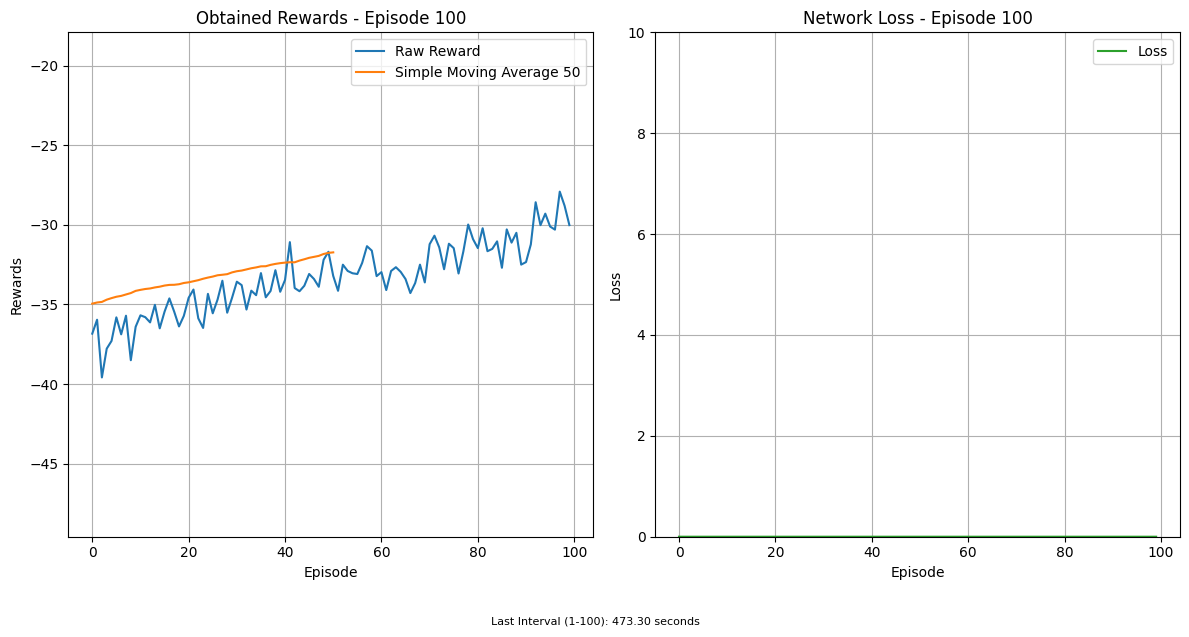

Episode: 100, Total Steps: 100000, Ep Step: 1000, Raw Reward: -30.02, Epsilon: 0.82
Episode: 101, Total Steps: 101000, Ep Step: 1000, Raw Reward: -29.72, Epsilon: 0.82
Episode: 102, Total Steps: 102000, Ep Step: 1000, Raw Reward: -28.39, Epsilon: 0.81
Episode: 103, Total Steps: 103000, Ep Step: 1000, Raw Reward: -29.78, Epsilon: 0.81
Episode: 104, Total Steps: 104000, Ep Step: 1000, Raw Reward: -30.56, Epsilon: 0.81
Episode: 105, Total Steps: 105000, Ep Step: 1000, Raw Reward: -31.85, Epsilon: 0.81
Episode: 106, Total Steps: 106000, Ep Step: 1000, Raw Reward: -30.84, Epsilon: 0.81
Episode: 107, Total Steps: 107000, Ep Step: 1000, Raw Reward: -30.07, Epsilon: 0.81
Episode: 108, Total Steps: 108000, Ep Step: 1000, Raw Reward: -28.92, Epsilon: 0.80
Episode: 109, Total Steps: 109000, Ep Step: 1000, Raw Reward: -28.78, Epsilon: 0.80
Episode: 110, Total Steps: 110000, Ep Step: 1000, Raw Reward: -29.52, Epsilon: 0.80
Episode: 111, Total Steps: 111000, Ep Step: 1000, Raw Reward: -28.95, Epsilo

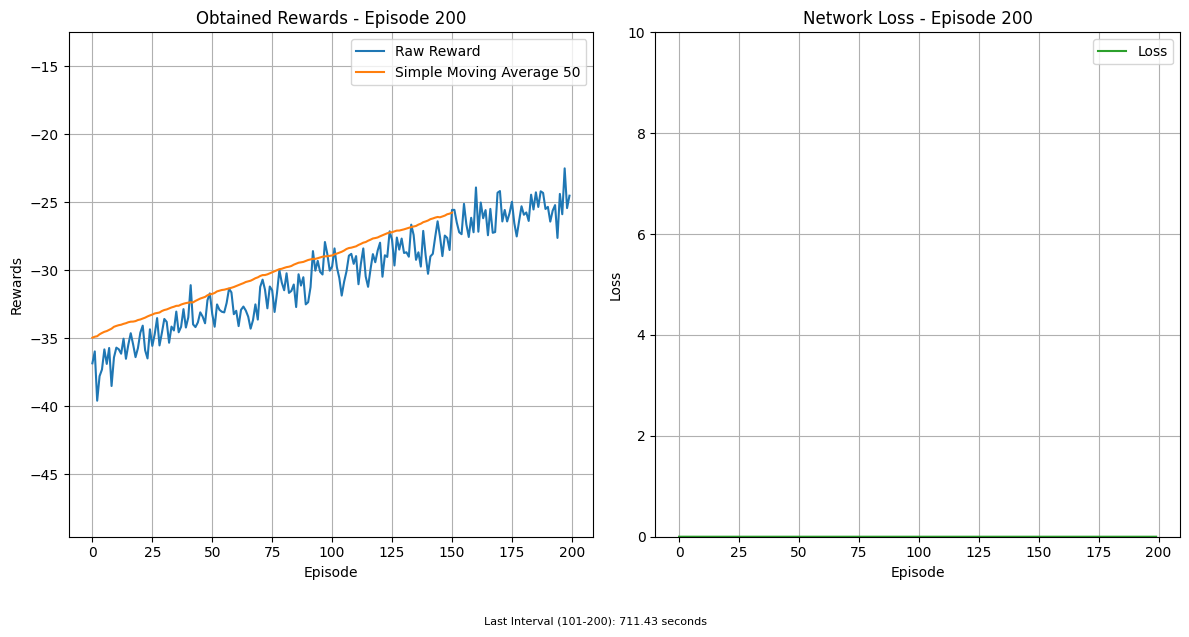

Episode: 200, Total Steps: 200000, Ep Step: 1000, Raw Reward: -24.51, Epsilon: 0.67
Episode: 201, Total Steps: 201000, Ep Step: 1000, Raw Reward: -25.23, Epsilon: 0.67
Episode: 202, Total Steps: 202000, Ep Step: 1000, Raw Reward: -25.86, Epsilon: 0.67
Episode: 203, Total Steps: 203000, Ep Step: 1000, Raw Reward: -25.60, Epsilon: 0.67
Episode: 204, Total Steps: 204000, Ep Step: 1000, Raw Reward: -25.03, Epsilon: 0.66
Episode: 205, Total Steps: 205000, Ep Step: 1000, Raw Reward: -23.80, Epsilon: 0.66
Episode: 206, Total Steps: 206000, Ep Step: 1000, Raw Reward: -22.29, Epsilon: 0.66
Episode: 207, Total Steps: 207000, Ep Step: 1000, Raw Reward: -24.26, Epsilon: 0.66
Episode: 208, Total Steps: 208000, Ep Step: 1000, Raw Reward: -25.27, Epsilon: 0.66
Episode: 209, Total Steps: 209000, Ep Step: 1000, Raw Reward: -24.19, Epsilon: 0.66
Episode: 210, Total Steps: 210000, Ep Step: 1000, Raw Reward: -22.85, Epsilon: 0.66
Episode: 211, Total Steps: 211000, Ep Step: 1000, Raw Reward: -26.26, Epsilo

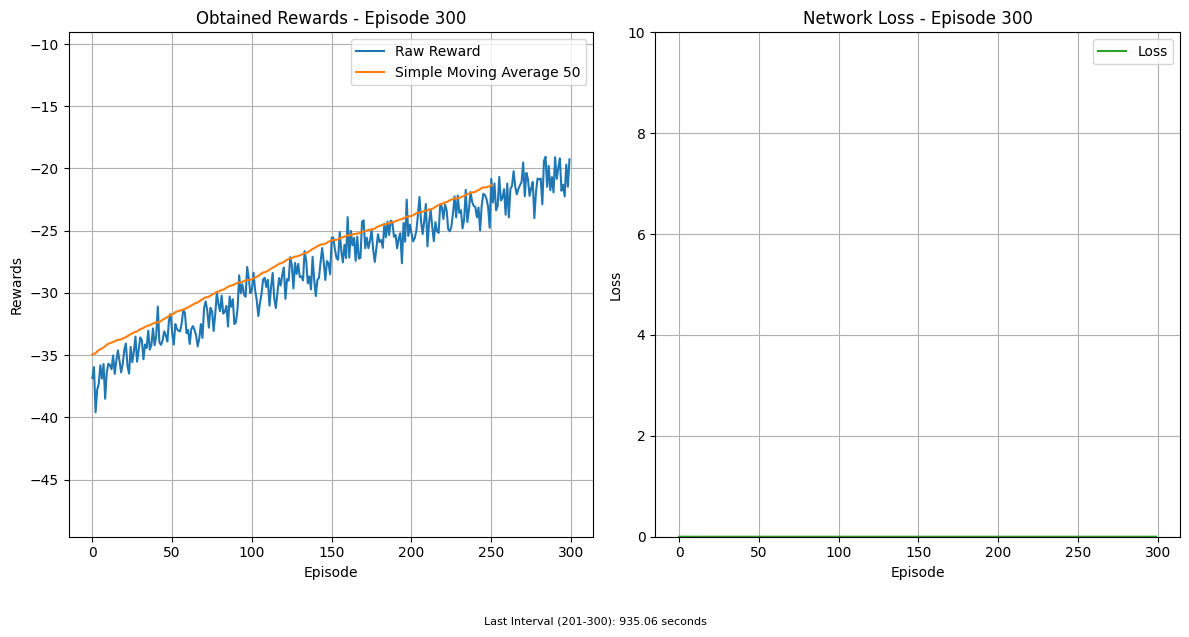

Episode: 300, Total Steps: 300000, Ep Step: 1000, Raw Reward: -19.26, Epsilon: 0.55
Episode: 301, Total Steps: 301000, Ep Step: 1000, Raw Reward: -21.83, Epsilon: 0.55
Episode: 302, Total Steps: 302000, Ep Step: 1000, Raw Reward: -19.92, Epsilon: 0.55
Episode: 303, Total Steps: 303000, Ep Step: 1000, Raw Reward: -19.56, Epsilon: 0.54
Episode: 304, Total Steps: 304000, Ep Step: 1000, Raw Reward: -19.85, Epsilon: 0.54
Episode: 305, Total Steps: 305000, Ep Step: 1000, Raw Reward: -20.15, Epsilon: 0.54
Episode: 306, Total Steps: 306000, Ep Step: 1000, Raw Reward: -21.57, Epsilon: 0.54
Episode: 307, Total Steps: 307000, Ep Step: 1000, Raw Reward: -20.70, Epsilon: 0.54
Episode: 308, Total Steps: 308000, Ep Step: 1000, Raw Reward: -20.21, Epsilon: 0.54
Episode: 309, Total Steps: 309000, Ep Step: 1000, Raw Reward: -20.74, Epsilon: 0.54
Episode: 310, Total Steps: 310000, Ep Step: 1000, Raw Reward: -21.04, Epsilon: 0.54
Episode: 311, Total Steps: 311000, Ep Step: 1000, Raw Reward: -20.20, Epsilo

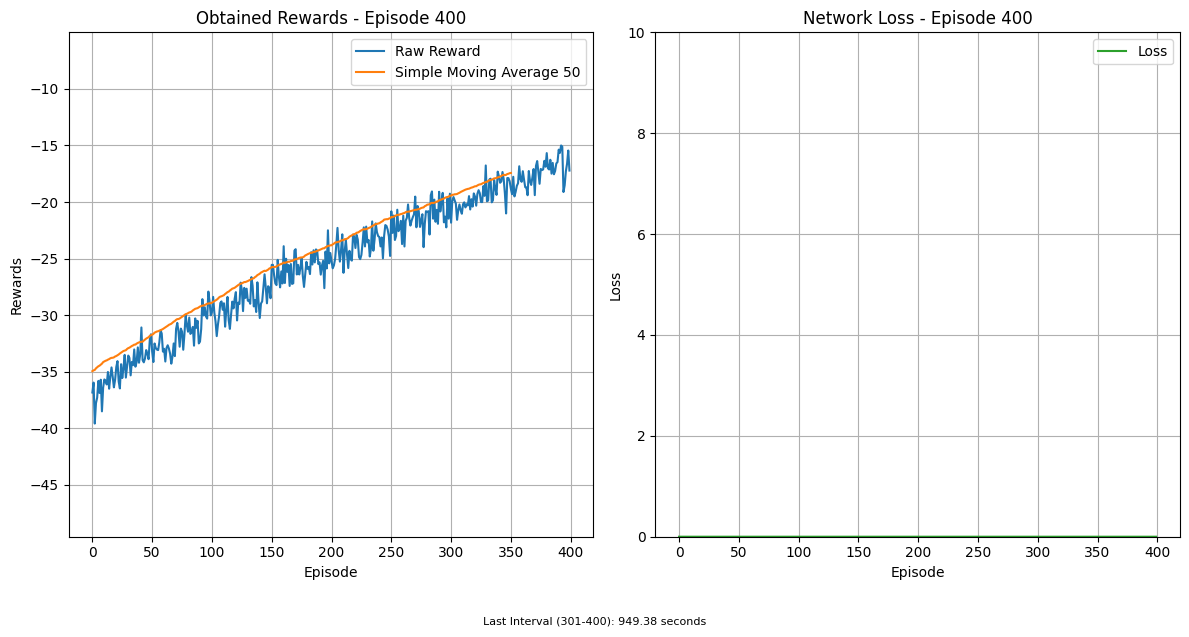

Episode: 400, Total Steps: 400000, Ep Step: 1000, Raw Reward: -17.22, Epsilon: 0.45
Episode: 401, Total Steps: 401000, Ep Step: 1000, Raw Reward: -17.21, Epsilon: 0.45
Episode: 402, Total Steps: 402000, Ep Step: 1000, Raw Reward: -17.71, Epsilon: 0.45
Episode: 403, Total Steps: 403000, Ep Step: 1000, Raw Reward: -15.58, Epsilon: 0.45
Episode: 404, Total Steps: 404000, Ep Step: 1000, Raw Reward: -16.35, Epsilon: 0.44
Episode: 405, Total Steps: 405000, Ep Step: 1000, Raw Reward: -15.99, Epsilon: 0.44
Episode: 406, Total Steps: 406000, Ep Step: 1000, Raw Reward: -17.11, Epsilon: 0.44
Episode: 407, Total Steps: 407000, Ep Step: 1000, Raw Reward: -15.94, Epsilon: 0.44
Episode: 408, Total Steps: 408000, Ep Step: 1000, Raw Reward: -17.35, Epsilon: 0.44
Episode: 409, Total Steps: 409000, Ep Step: 1000, Raw Reward: -17.73, Epsilon: 0.44
Episode: 410, Total Steps: 410000, Ep Step: 1000, Raw Reward: -17.59, Epsilon: 0.44
Episode: 411, Total Steps: 411000, Ep Step: 1000, Raw Reward: -17.31, Epsilo

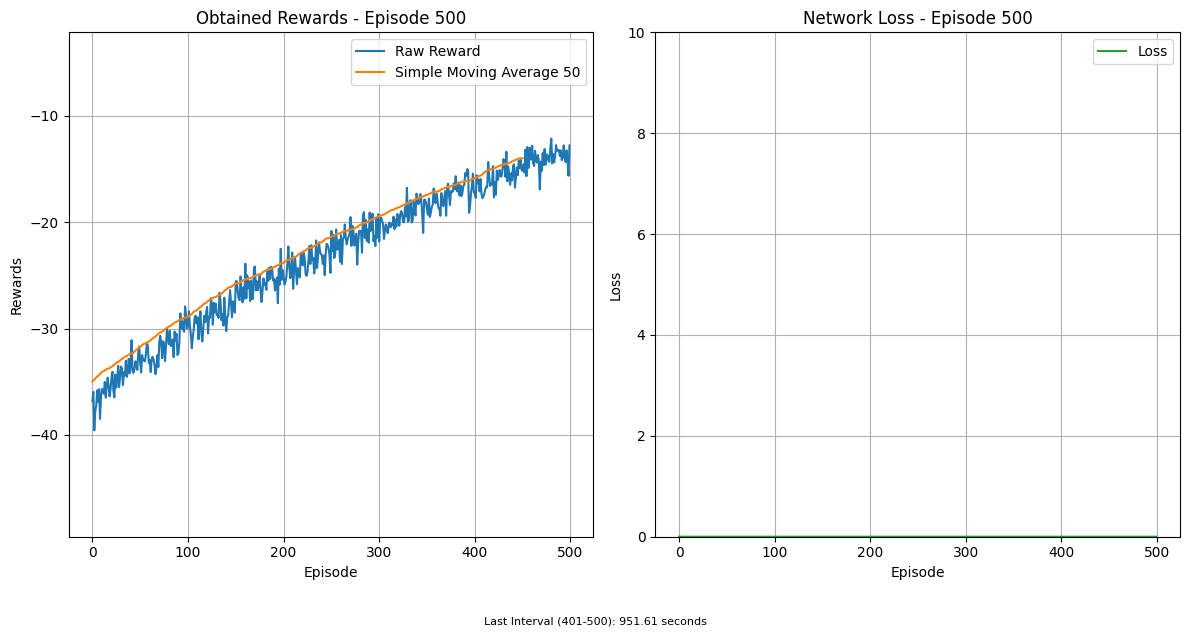

Episode: 500, Total Steps: 500000, Ep Step: 1000, Raw Reward: -12.78, Epsilon: 0.37
Episode: 501, Total Steps: 501000, Ep Step: 1000, Raw Reward: -13.35, Epsilon: 0.37
Episode: 502, Total Steps: 502000, Ep Step: 1000, Raw Reward: -13.27, Epsilon: 0.37
Episode: 503, Total Steps: 503000, Ep Step: 1000, Raw Reward: -14.27, Epsilon: 0.36
Episode: 504, Total Steps: 504000, Ep Step: 1000, Raw Reward: -12.57, Epsilon: 0.36
Episode: 505, Total Steps: 505000, Ep Step: 1000, Raw Reward: -13.83, Epsilon: 0.36
Episode: 506, Total Steps: 506000, Ep Step: 1000, Raw Reward: -12.21, Epsilon: 0.36
Episode: 507, Total Steps: 507000, Ep Step: 1000, Raw Reward: -12.82, Epsilon: 0.36
Episode: 508, Total Steps: 508000, Ep Step: 1000, Raw Reward: -13.57, Epsilon: 0.36
Episode: 509, Total Steps: 509000, Ep Step: 1000, Raw Reward: -13.78, Epsilon: 0.36
Episode: 510, Total Steps: 510000, Ep Step: 1000, Raw Reward: -14.29, Epsilon: 0.36
Episode: 511, Total Steps: 511000, Ep Step: 1000, Raw Reward: -15.30, Epsilo

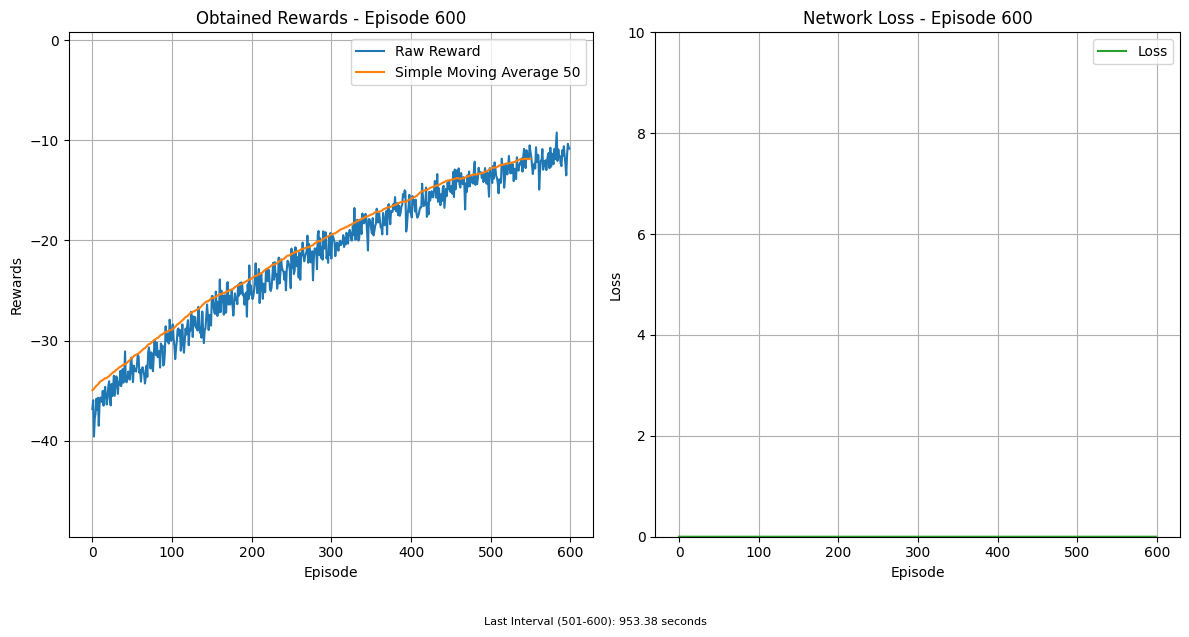

Episode: 600, Total Steps: 600000, Ep Step: 1000, Raw Reward: -10.84, Epsilon: 0.30
Episode: 601, Total Steps: 601000, Ep Step: 1000, Raw Reward: -10.58, Epsilon: 0.30
Episode: 602, Total Steps: 602000, Ep Step: 1000, Raw Reward: -10.90, Epsilon: 0.30
Episode: 603, Total Steps: 603000, Ep Step: 1000, Raw Reward: -12.04, Epsilon: 0.30
Episode: 604, Total Steps: 604000, Ep Step: 1000, Raw Reward: -11.20, Epsilon: 0.30
Episode: 605, Total Steps: 605000, Ep Step: 1000, Raw Reward: -10.73, Epsilon: 0.30
Episode: 606, Total Steps: 606000, Ep Step: 1000, Raw Reward: -10.96, Epsilon: 0.30
Episode: 607, Total Steps: 607000, Ep Step: 1000, Raw Reward: -10.28, Epsilon: 0.30
Episode: 608, Total Steps: 608000, Ep Step: 1000, Raw Reward: -9.36, Epsilon: 0.30
Episode: 609, Total Steps: 609000, Ep Step: 1000, Raw Reward: -11.45, Epsilon: 0.30
Episode: 610, Total Steps: 610000, Ep Step: 1000, Raw Reward: -12.30, Epsilon: 0.29
Episode: 611, Total Steps: 611000, Ep Step: 1000, Raw Reward: -10.32, Epsilon

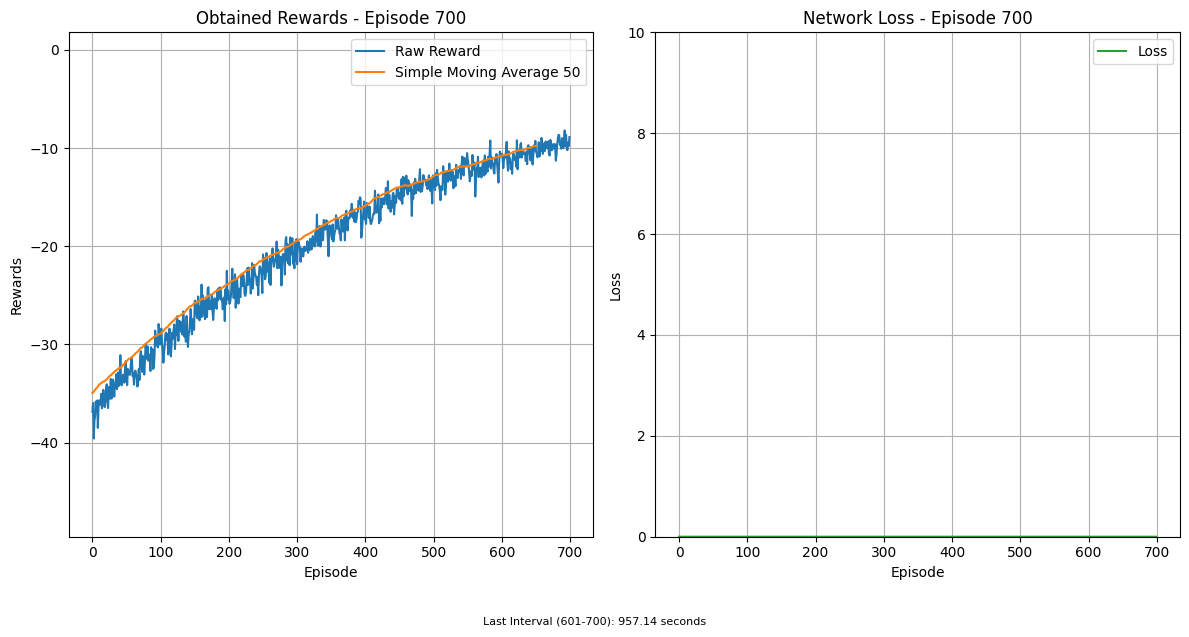

Episode: 700, Total Steps: 700000, Ep Step: 1000, Raw Reward: -8.87, Epsilon: 0.25
Episode: 701, Total Steps: 701000, Ep Step: 1000, Raw Reward: -9.00, Epsilon: 0.25
Episode: 702, Total Steps: 702000, Ep Step: 1000, Raw Reward: -8.96, Epsilon: 0.25
Episode: 703, Total Steps: 703000, Ep Step: 1000, Raw Reward: -8.90, Epsilon: 0.24
Episode: 704, Total Steps: 704000, Ep Step: 1000, Raw Reward: -10.56, Epsilon: 0.24
Episode: 705, Total Steps: 705000, Ep Step: 1000, Raw Reward: -9.49, Epsilon: 0.24
Episode: 706, Total Steps: 706000, Ep Step: 1000, Raw Reward: -8.60, Epsilon: 0.24
Episode: 707, Total Steps: 707000, Ep Step: 1000, Raw Reward: -10.60, Epsilon: 0.24
Episode: 708, Total Steps: 708000, Ep Step: 1000, Raw Reward: -10.29, Epsilon: 0.24
Episode: 709, Total Steps: 709000, Ep Step: 1000, Raw Reward: -9.05, Epsilon: 0.24
Episode: 710, Total Steps: 710000, Ep Step: 1000, Raw Reward: -9.20, Epsilon: 0.24
Episode: 711, Total Steps: 711000, Ep Step: 1000, Raw Reward: -9.43, Epsilon: 0.24
E

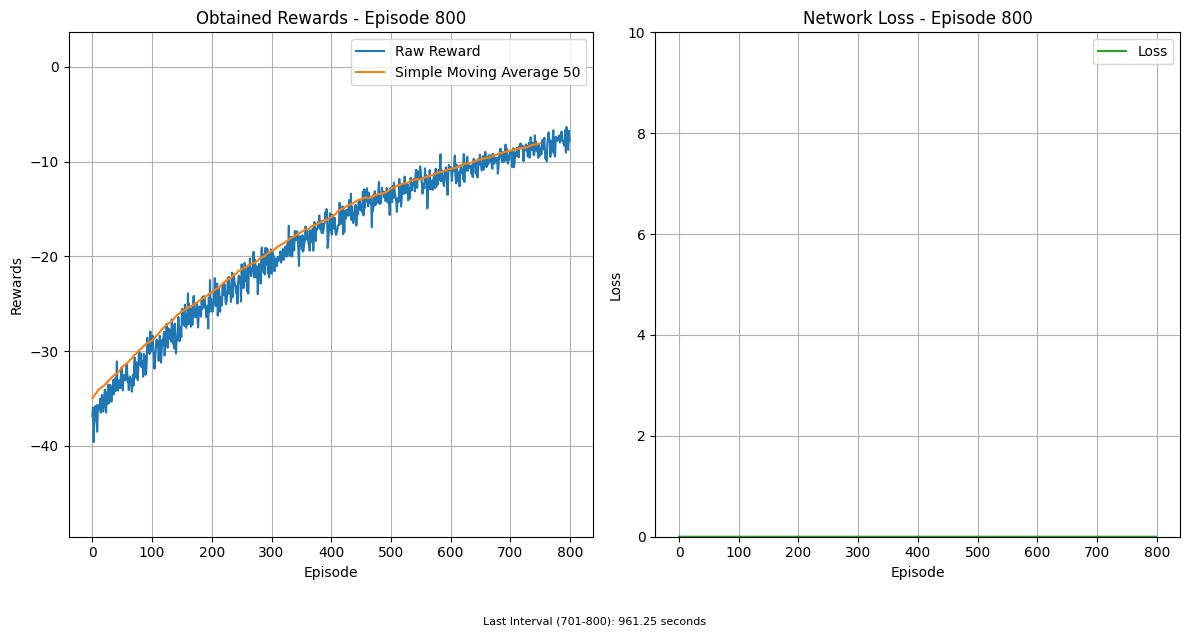

Episode: 800, Total Steps: 800000, Ep Step: 1000, Raw Reward: -7.80, Epsilon: 0.20
Episode: 801, Total Steps: 801000, Ep Step: 1000, Raw Reward: -7.34, Epsilon: 0.20
Episode: 802, Total Steps: 802000, Ep Step: 1000, Raw Reward: -7.67, Epsilon: 0.20
Episode: 803, Total Steps: 803000, Ep Step: 1000, Raw Reward: -6.08, Epsilon: 0.20
Episode: 804, Total Steps: 804000, Ep Step: 1000, Raw Reward: -7.23, Epsilon: 0.20
Episode: 805, Total Steps: 805000, Ep Step: 1000, Raw Reward: -7.34, Epsilon: 0.20
Episode: 806, Total Steps: 806000, Ep Step: 1000, Raw Reward: -8.34, Epsilon: 0.20
Episode: 807, Total Steps: 807000, Ep Step: 1000, Raw Reward: -6.24, Epsilon: 0.20
Episode: 808, Total Steps: 808000, Ep Step: 1000, Raw Reward: -7.59, Epsilon: 0.20
Episode: 809, Total Steps: 809000, Ep Step: 1000, Raw Reward: -6.79, Epsilon: 0.20
Episode: 810, Total Steps: 810000, Ep Step: 1000, Raw Reward: -7.69, Epsilon: 0.20
Episode: 811, Total Steps: 811000, Ep Step: 1000, Raw Reward: -8.06, Epsilon: 0.20
Epis

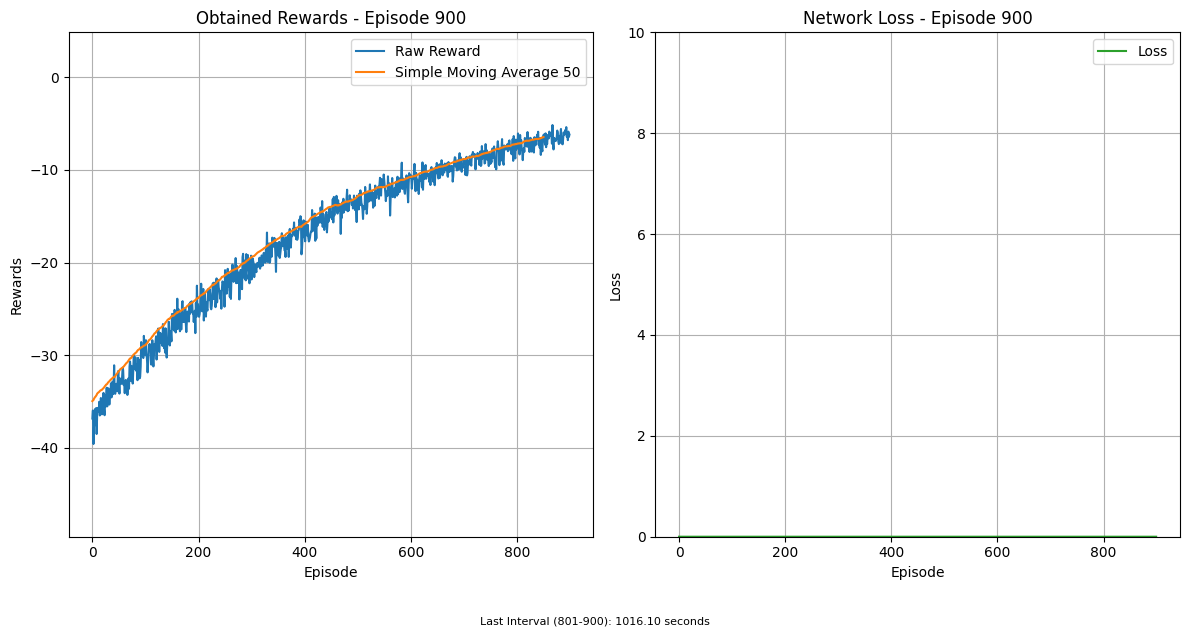

Episode: 900, Total Steps: 900000, Ep Step: 1000, Raw Reward: -6.20, Epsilon: 0.16
Episode: 901, Total Steps: 901000, Ep Step: 1000, Raw Reward: -7.76, Epsilon: 0.16
Episode: 902, Total Steps: 902000, Ep Step: 1000, Raw Reward: -6.43, Epsilon: 0.16
Episode: 903, Total Steps: 903000, Ep Step: 1000, Raw Reward: -6.18, Epsilon: 0.16
Episode: 904, Total Steps: 904000, Ep Step: 1000, Raw Reward: -7.18, Epsilon: 0.16
Episode: 905, Total Steps: 905000, Ep Step: 1000, Raw Reward: -7.36, Epsilon: 0.16
Episode: 906, Total Steps: 906000, Ep Step: 1000, Raw Reward: -6.37, Epsilon: 0.16
Episode: 907, Total Steps: 907000, Ep Step: 1000, Raw Reward: -5.54, Epsilon: 0.16
Episode: 908, Total Steps: 908000, Ep Step: 1000, Raw Reward: -5.78, Epsilon: 0.16
Episode: 909, Total Steps: 909000, Ep Step: 1000, Raw Reward: -5.99, Epsilon: 0.16
Episode: 910, Total Steps: 910000, Ep Step: 1000, Raw Reward: -6.13, Epsilon: 0.16
Episode: 911, Total Steps: 911000, Ep Step: 1000, Raw Reward: -6.21, Epsilon: 0.16
Epis

KeyboardInterrupt: 

In [8]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models lr"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Learning rate values to test
learning_rates = [0.001, 0.01, 0.1, 0.5]

# Loop through different learning rates
for lr in learning_rates:
    print(f"\n### Training with Learning Rate: {lr} ###\n")
    
    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_lr_{lr}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": lr,  # Current learning rate
        "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
        "batch_size": 128,  # Batch size for training updates
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": 0.998,  # Decay rate for epsilon
        "memory_capacity": 250_000,  # Capacity for replay memory
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Random seed for reproducibility
    }

    # Initialize the environment
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current learning rate
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed)

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with Learning Rate: {lr} ###\n")

### 2. **Discount Factor ($\gamma$)**:
   - Determines the importance of future rewards.
   - Values to test: $0.5$, $0.7$, $0.9$, $0.99$.

In [52]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models gamma"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Discount factor values to test
discount_factors = [0.5, 0.7, 0.9, 0.99]

# Loop through different discount factors
for gamma in discount_factors:
    print(f"\n### Training with Discount Factor (γ): {gamma} ###\n")
    
    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_gamma_{gamma}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": 0.01,  # Learning rate for training the agent
        "discount_factor": gamma,  # Current discount factor
        "batch_size": 128,  # Batch size for training updates
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": 0.998,  # Decay rate for epsilon
        "memory_capacity": 250_000,  # Capacity for replay memory
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Random seed for reproducibility
    }

    # Initialize the environment
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current discount factor
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed)

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with Discount Factor (γ): {gamma} ###\n")


### Training with Discount Factor (γ): 0.5 ###

Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -35.96, Epsilon: 1.00


KeyboardInterrupt: 

### 3. **Exploration Rate Decay ($\epsilon_{\text{decay}}$)**:
   - Affects how quickly the exploration rate decreases over time.
   - Values to test: $0.99$, $0.995$, $0.998$, $0.999$.

In [53]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models decay"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Exploration rate decay values to test
epsilon_decay_values = [0.99, 0.995, 0.998, 0.999]

# Loop through different exploration rate decays
for epsilon_decay in epsilon_decay_values:
    print(f"\n### Training with Exploration Rate Decay (ε_decay): {epsilon_decay} ###\n")
    
    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_epsilon_decay_{epsilon_decay}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": 0.01,  # Learning rate for training the agent
        "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
        "batch_size": 128,  # Batch size for training updates
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": epsilon_decay,  # Current exploration rate decay
        "memory_capacity": 250_000,  # Capacity for replay memory
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Random seed for reproducibility
    }

    # Initialize the environment
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current exploration rate decay
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed)

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with Exploration Rate Decay (ε_decay): {epsilon_decay} ###\n")



### Training with Exploration Rate Decay (ε_decay): 0.99 ###

Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 0.99
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -36.16, Epsilon: 0.98
Episode: 3, Total Steps: 3000, Ep Step: 1000, Raw Reward: -39.28, Epsilon: 0.97


KeyboardInterrupt: 

### 4. **Replay Memory Capacity**:
   - Determines how many transitions are stored in the replay buffer.
   - Values to test: $10,000$, $50,000$, $100,000$, $250,000$.

In [54]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models memory"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Replay memory capacity values to test
memory_capacities = [10_000, 50_000, 100_000, 250_000]

# Loop through different replay memory capacities
for memory_capacity in memory_capacities:
    print(f"\n### Training with Replay Memory Capacity: {memory_capacity} ###\n")
    
    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_memory_{memory_capacity}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": 0.01,  # Learning rate for training the agent
        "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
        "batch_size": 128,  # Batch size for training updates
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": 0.998,  # Decay rate for epsilon
        "memory_capacity": memory_capacity,  # Current replay memory capacity
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Random seed for reproducibility
    }

    # Initialize the environment
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current replay memory capacity
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed)

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with Replay Memory Capacity: {memory_capacity} ###\n")



### Training with Replay Memory Capacity: 10000 ###

Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -36.20, Epsilon: 1.00
Episode: 3, Total Steps: 3000, Ep Step: 1000, Raw Reward: -39.68, Epsilon: 0.99


KeyboardInterrupt: 

### 5. **Batch Size**:
   - Controls the number of transitions sampled from the replay memory for each training update.
   - Values to test: $32$, $64$, $128$, $256$.


In [ ]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models batch"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Batch size values to test
batch_sizes = [32, 64, 128, 256]

# Loop through different batch sizes
for batch_size in batch_sizes:
    print(f"\n### Training with Batch Size: {batch_size} ###\n")
    
    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_batch_{batch_size}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": 0.01,  # Learning rate for training the agent
        "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
        "batch_size": batch_size,  # Current batch size
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": 0.998,  # Decay rate for epsilon
        "memory_capacity": 250_000,  # Capacity for replay memory
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Random seed for reproducibility
    }

    # Initialize the environment
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current batch size
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed)

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with Batch Size: {batch_size} ###\n")


### 6. **Number of Discretized Action Bins**

In [36]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models bins"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Number of bins values to test
num_bins_values = [10, 20, 50, 100]

# Loop through different num_bins values
for num_bins in num_bins_values:
    print(f"\n### Training with num_bins: {num_bins} ###\n")
    
    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_num_bins_{num_bins}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": 0.01,  # Learning rate for training the agent
        "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
        "batch_size": 128,  # Batch size for training updates
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": 0.998,  # Decay rate for epsilon
        "memory_capacity": 250_000,  # Capacity for replay memory
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Random seed for reproducibility
    }

    # Initialize the environment with the current num_bins
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=num_bins)  # Discretize the continuous action space with the current num_bins
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current num_bins
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed)

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with num_bins: {num_bins} ###\n")



### Training with num_bins: 10 ###



TypeError: DQN_Network.init_weights() takes 1 positional argument but 2 were given

### 7. **Hidden Layer Dimensions**

In [34]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models layers"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Hidden layer dimension values to test
hidden_layer_dimensions = [32, 64, 128, 256]

# Loop through different hidden layer dimensions
for hidden_dim in hidden_layer_dimensions:
    print(f"\n### Training with Hidden Layer Dimension: {hidden_dim} ###\n")
    
    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_hidden_dim_{hidden_dim}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": 0.01,  # Learning rate for training the agent
        "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
        "batch_size": 128,  # Batch size for training updates
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": 0.998,  # Decay rate for epsilon
        "memory_capacity": 250_000,  # Capacity for replay memory
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Random seed for reproducibility
    }

    # Initialize the environment
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current hidden layer dimension
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed,
                      hidden_dim=hidden_dim
                      )

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)
    
    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with Hidden Layer Dimension: {hidden_dim} ###\n")


### Training with Hidden Layer Dimension: 32 ###

DQN_Network(
  (FC): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=20, bias=True)
  )
)
Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00


KeyboardInterrupt: 

### 8. **Different Seeds**

In [38]:
# Set up the path for saving model checkpoints
save_dir = "saved models seeds"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Seed values to test
seed_values = [0, 42, 100, 1234, 9999]

# Loop through different seeds
for seed in seed_values:
    print(f"\n### Training with Seed: {seed} ###\n")
    
    # Set seed for reproducibility
    set_seed(seed)

    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_seed_{seed}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": 0.01,  # Learning rate for training the agent
        "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
        "batch_size": 128,  # Batch size for training updates
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": 0.998,  # Decay rate for epsilon
        "memory_capacity": 250_000,  # Capacity for replay memory
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Current seed
    }

    # Initialize the environment
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current seed
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed)

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with Seed: {seed} ###\n")


### Training with Seed: 0 ###



TypeError: super(type, obj): obj must be an instance or subtype of type

### 9. **Two Hidden Layers**

In [30]:
class DQN_Network_Deep(nn.Module):
    """
    The Deep Q-Network (DQN) model for reinforcement learning.
    
    This network approximates the Q-value function, which predicts the expected 
    cumulative reward for each possible action in a given state. The architecture 
    consists of fully connected (FC) layers with ReLU activation functions.
    """

    def __init__(self, num_actions, input_dim, hidden_dim=64):
        """
        Initialize the DQN network.

        Args:
            num_actions (int): The number of possible actions in the environment. 
                               This determines the size of the output layer.
            input_dim (int): The dimensionality of the input state space, i.e., the 
                             number of features describing the state.
            hidden_dim (int, optional): The number of units in the hidden layers. 
                                        Default is 64.
        """
        super(DQN_Network_Deep, self).__init__()
        
        # Define the fully connected layers of the network
        self.FC = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Input to first hidden layer
            nn.ReLU(inplace=True),            # Activation function
            nn.Linear(hidden_dim, hidden_dim),  # First hidden to second hidden layer
            nn.ReLU(inplace=True),            # Activation function
            nn.Linear(hidden_dim, num_actions)  # Second hidden to output layer
        )
        
        # Apply Xavier Initialization to all Linear layers
        self.FC.apply(self.init_weights)

    def init_weights(self, layer):
        """
        Initialize weights for Linear layers using Xavier Uniform initialization.
        
        Xavier initialization ensures that the variance of the activations remains 
        consistent across layers, preventing vanishing or exploding gradients. 
        This is particularly effective for activation functions like ReLU.
        
        Args:
            layer (nn.Module): A layer in the neural network. If it is a Linear 
                               layer, its weights and biases are initialized.
        """
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)  # Initialize weights
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)  # Initialize biases to zero

    def forward(self, x):
        """
        Perform the forward pass to compute Q-values for each action.

        The forward pass processes the input state through the fully connected 
        layers, applying the ReLU activation in the hidden layers, and outputs 
        the Q-values for all possible actions.

        Args:
            x (torch.Tensor): A tensor representing the state of the environment. 
                              Shape: (batch_size, input_dim).

        Returns:
            torch.Tensor: A tensor containing Q-values for each action. 
                          Shape: (batch_size, num_actions).
        """
        return self.FC(x)


In [32]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models deep"
os.makedirs(save_dir, exist_ok=True)

# Parameters for training
train_mode = True  # We are training, not testing
render = not train_mode  # If not training, render the environment

# Hidden layer dimension values to test
hidden_layer_dimensions = [32, 64, 128, 256]

# Loop through different hidden layer dimensions
for hidden_dim in hidden_layer_dimensions:
    print(f"\n### Training with (Two) Hidden Layer Dimension: {hidden_dim} ###\n")
    
    # Define hyperparameters for the current run
    hyperparams = {
        "load_path": None,  # Path to load the pre-trained model, None during training
        "save_path": os.path.join(save_dir, f"model_checkpoint_hidden_dim_{hidden_dim}"),  # Path to save model checkpoints
        "save_interval": 100,  # Interval at which the model will be saved (in episodes)
        "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
        "learning_rate": 0.01,  # Learning rate for training the agent
        "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
        "batch_size": 128,  # Batch size for training updates
        "update_frequency": 50,  # Number of steps before updating the target network
        "max_episodes": 1000,  # Maximum number of episodes for training
        "max_steps": 1000,  # Maximum number of steps per episode
        "epsilon_max": 0.999,  # Exploration rate (epsilon) for epsilon-greedy policy
        "epsilon_min": 0.01,  # Minimum exploration rate
        "epsilon_decay": 0.998,  # Decay rate for epsilon
        "memory_capacity": 250_000,  # Capacity for replay memory
        "render_fps": 60,  # Frames per second for rendering the environment
        "seed": seed  # Random seed for reproducibility
    }

    # Initialize the environment
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
                   render_mode="human" if render else None)
    env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

    # Apply wrappers to the environment
    env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
    env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

    # Initialize the agent with the current hidden layer dimension
    agent = DQN_Agent(env=env,
                      epsilon_max=hyperparams["epsilon_max"],
                      epsilon_min=hyperparams["epsilon_min"],
                      epsilon_decay=hyperparams["epsilon_decay"],
                      clip_grad_norm=hyperparams["clip_grad_norm"],
                      learning_rate=hyperparams["learning_rate"],
                      discount=hyperparams["discount_factor"],
                      memory_capacity=hyperparams["memory_capacity"],
                      seed=seed,
                      network_class=DQN_Network_Deep,
                      hidden_dim=hidden_dim
                      )

    # Initialize the training procedure
    dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

    # Train the model
    dqn_trainer.run(mode='train')

    print(f"### Finished Training with Hidden Layer Dimension: {hidden_dim} ###\n")


### Training with (Two) Hidden Layer Dimension: 32 ###

DQN_Network_Deep(
  (FC): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
)
Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00


KeyboardInterrupt: 

### 10. **Optimized Model with Modified Reward Function**

In [40]:
class modified_reward_wrapper(gym.RewardWrapper):
    """
    A wrapper for customizing rewards in the environment.

    This wrapper penalizes large actions and provides a bonus for achieving the goal.

    Args:
        env (gym.Env): The environment to wrap.
    """
    def __init__(self, env):
        """
        Initialize the reward wrapper.

        Args:
            env (gym.Env): The environment to wrap.
        """
        super().__init__(env)

    def reward(self, state, action):
        """
        Compute a modified reward based on the current state and action.

        - Encourages progress toward the goal by rewarding proximity.
        - Penalizes unnecessary steps and actions with high magnitudes.
        - Adds bonuses for desirable behaviors like sustained velocity and reaching the goal.

        Args:
            state (numpy.ndarray): The current state of the environment.
            action (int): The action taken.

        Returns:
            float: The modified reward.
        """
        position, velocity = state
        continuous_action = self.env.discrete_actions[action]
    
        # Base reward to encourage goal progress
        #reward = 0.2 * (np.cos(position * 360 * np.pi / 180) + 2 * np.abs(velocity))
    
        # Penalty for unnecessary steps
        #reward -= 0.5  # Base penalty to discourage unnecessary steps
    
        reward = 0

        # Bonus for getting closer to the goal
        if position > 0.98:
            reward += 20  # Reached the goal
        elif position > 0.92:
            reward += 10  # Very close to the goal
        elif position > 0.82:
            reward += 6  # Approaching the goal
        elif position > 0.65:
            reward += 1 - np.exp(-2 * position)  # Reward for progress

        # Bonus for moving right with sufficient velocity
        if velocity > 0.3 and position > 0.5:
            reward += 1 + 2 * position
    
        # Penalize large action magnitudes
        reward -= 0.1 * (continuous_action ** 2)
    
        return reward

In [41]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models modified reward"
# Ensure the "saved models" directory exists
os.makedirs(save_dir, exist_ok=True)

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "epsilon_max": 0.999 if train_mode else 0,  # Exploration rate (epsilon) for epsilon-greedy policy
    "epsilon_min": 0.01,  # Minimum exploration rate
    "epsilon_decay": 0.998,  # Decay rate for epsilon
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "seed": seed  # Random seed for reproducibility
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env, reward_function=modified_reward_wrapper)  # Apply step wrapper for observation and reward modifications

# Initialize the agent with the provided hyperparameters
agent = DQN_Agent(env=env,
                  epsilon_max=hyperparams["epsilon_max"],
                  epsilon_min=hyperparams["epsilon_min"],
                  epsilon_decay=hyperparams["epsilon_decay"],
                  clip_grad_norm=hyperparams["clip_grad_norm"],
                  learning_rate=hyperparams["learning_rate"],
                  discount=hyperparams["discount_factor"],
                  memory_capacity=hyperparams["memory_capacity"],
                  seed=seed)

# Initialize the training or testing procedure
dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
# Create the "saved models" folder if it does not exist
    save_dir = "saved models"
    os.makedirs(save_dir, exist_ok=True)
    dqn_trainer.run(mode='train')  # Train the model
else:
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")  # Path to the current checkpoint
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the DQN trainer with updated hyperparameters
        dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete


Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: 410.11, Epsilon: 1.00
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -36.25, Epsilon: 1.00


KeyboardInterrupt: 

---

# 4) Advanced Algorithms (DQN Improvements)

## 1. Prioritized experience replay


PER enhances traditional Experience Replay in DQN by prioritizing transitions that are more impactful for learning, leading to faster convergence and improved sample efficiency.


### Key Concepts

1. **Priority Assignment**:

   - Experiences are prioritized based on Temporal Difference (TD) errors:
     $
     p_i = |\delta_i| + \epsilon
     $
     where $ \epsilon $ ensures non-zero priority.

2. **Sampling Probability**:

   - Transitions are sampled with probability proportional to their priority:
     $
     P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}
     $
     $ \alpha $ determines the prioritization level.

3. **Importance Sampling (IS) Weights**:
   - Corrects sampling bias:

     $
     w_i = \left( \frac{1}{N \cdot P(i)} \right)^\beta
     $
     $ \beta $ anneals to 1 over time.

4. **Updating Priorities**:
   - Priorities are updated after learning using new TD errors.


### Benefits

- **Faster Convergence**: Focuses on transitions with higher learning potential.
- **Improved Efficiency**: Reduces the number of samples needed.
- **Handles Sparse Rewards**: Highlights rare but informative experiences.


### Practical Considerations

- **Hyperparameters**:
  - $ \alpha $: Controls prioritization (e.g., 0.4–0.7).
  - $ \beta $: Adjusts bias correction (starts small, anneals to 1).
  - $ \epsilon $: Small constant (e.g., $ 1e{-6} $).
- **Overhead**: Efficient data structures (e.g., sum-trees) mitigate additional complexity.

### CODE UPDATES

####  &nbsp; a) Modify the Replay Memory

Replace the current `ReplayMemory` class with one that supports PER. PER assigns a priority to each transition and samples transitions based on their priorities.

**Key Changes in ReplayMemory**:
- Use a data structure that supports efficient sampling and updating of priorities, such as a **Segment Tree**.
- Assign an initial priority to new transitions (commonly the maximum priority so new experiences get a chance to be sampled).
- Adjust the sampling method to sample based on priorities.

In [8]:
class PrioritizedReplayMemory(ReplayMemory):
    """
    A prioritized replay memory buffer that stores and samples transitions with probabilities
    proportional to their TD-error magnitude.

    Attributes:
        alpha (float): Controls the level of prioritization (0 corresponds to uniform sampling).
        epsilon (float): Small constant added to priorities to avoid zero values.
        priorities (np.ndarray): Array storing the priority values of the transitions.
    """

    def __init__(self, capacity, state_dim, action_dim, device, alpha=0.6, epsilon=1e-6):
        """
        Initializes the PrioritizedReplayMemory.

        Args:
            capacity (int): Maximum number of transitions the buffer can hold.
            state_dim (int): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            device (torch.device): Device to store the tensors (e.g., CPU or GPU).
            alpha (float): Prioritization exponent (default: 0.6).
            epsilon (float): Small constant to prevent zero priorities (default: 1e-6).
        """
        super().__init__(capacity, state_dim, action_dim, device)
        self.alpha = alpha  # Controls prioritization level
        self.epsilon = epsilon  # Small value to avoid zero priorities
        self.priorities = np.zeros((capacity,), dtype=np.float32)  # Priority values

    def store(self, state, action, next_state, reward, terminated):
        """
        Stores a transition in the replay buffer and sets its priority to the maximum priority.

        Args:
            state (np.ndarray): The current state.
            action (np.ndarray): The action taken.
            next_state (np.ndarray): The next state after taking the action.
            reward (float): The reward received after taking the action.
            terminated (bool): Whether the episode has terminated.
        """
        super().store(state, action, next_state, reward, terminated)
        max_priority = self.priorities.max() if self.current_idx > 0 else 1.0
        self.priorities[self.current_idx - 1] = max_priority + self.epsilon  # Add epsilon to avoid zero

    def sample(self, batch_size, beta=0.4):
        """
        Samples a batch of transitions from the replay buffer based on their priorities.

        Args:
            batch_size (int): Number of transitions to sample.
            beta (float): Importance-sampling exponent (default: 0.4).

        Returns:
            tuple: A tuple containing sampled states, actions, next states, rewards, terminated flags,
                   importance-sampling weights, and indices of the sampled transitions.
        """
        upper_bound = self.capacity if self.is_full else self.current_idx
        priorities = self.priorities[:upper_bound] + self.epsilon  # Prevent zeros in priorities

        # Compute sampling probabilities
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        # Sample indices based on probabilities
        indices = np.random.choice(upper_bound, size=batch_size, p=probabilities)

        # Importance-sampling weights
        weights = (len(probabilities) * probabilities[indices]) ** -beta
        weights /= weights.max()  # Normalize weights

        # Retrieve sampled transitions
        states = torch.as_tensor(self.states[indices], device=self.device)
        actions = torch.as_tensor(self.actions[indices], device=self.device, dtype=torch.int64)
        next_states = torch.as_tensor(self.next_states[indices], device=self.device)
        rewards = torch.as_tensor(self.rewards[indices], device=self.device)
        terminateds = torch.as_tensor(self.terminateds[indices], device=self.device)
        weights = torch.tensor(weights, dtype=torch.float32, device=self.device)

        return states, actions, next_states, rewards, terminateds, weights, indices

    def update_priorities(self, indices, td_errors):
        """
        Updates the priorities of sampled transitions based on their TD-errors.

        Args:
            indices (np.ndarray): Indices of the sampled transitions.
            td_errors (np.ndarray): TD-errors of the sampled transitions.
        """
        for idx, error in zip(indices, td_errors):
            self.priorities[idx] = abs(error) + self.epsilon  # Add epsilon to prevent zero

####  &nbsp; b) **Update the `DQN_Agent` Class**

Incorporate PER into the agent's learning process. Specifically:
- Compute the TD error for each transition and use it to update priorities.
- Use importance-sampling weights during the loss calculation.


In [9]:
class DQN_Agent_PER(DQN_Agent):
    """
    A DQN agent with Prioritized Experience Replay (PER) for enhanced training.

    Attributes:
        replay_memory (PrioritizedReplayMemory): The prioritized replay memory to store experiences.
    """
    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay, 
                 clip_grad_norm, learning_rate, discount, memory_capacity, seed, alpha=0.6, network_class=DQN_Network):
        """
        Initializes the DQN agent with PER.

        Args:
            env (gym.Env): The environment to interact with.
            epsilon_max (float): Initial value for epsilon in epsilon-greedy exploration.
            epsilon_min (float): Minimum value for epsilon.
            epsilon_decay (float): Decay rate for epsilon.
            clip_grad_norm (float): Gradient clipping norm.
            learning_rate (float): Learning rate for the optimizer.
            discount (float): Discount factor for future rewards.
            memory_capacity (int): Capacity of the replay memory.
            seed (int): Random seed for reproducibility.
            alpha (float, optional): Prioritization level for PER (default is 0.6).
            network_class (type, optional): Class of the Q-network (default is DQN_Network).
        """
        super().__init__(env, epsilon_max, epsilon_min, epsilon_decay, 
                         clip_grad_norm, learning_rate, discount, memory_capacity, seed, network_class=network_class)
        
        # Replace the replay memory with a PrioritizedReplayMemory
        self.replay_memory = PrioritizedReplayMemory(
            capacity=memory_capacity,
            state_dim=env.observation_space.shape,
            action_dim=1,
            device=device,
            alpha=alpha
        )
    
    def learn(self, batch_size, done, beta=0.4):
        """
        Performs a learning step using a batch of experiences sampled from the replay memory.

        Args:
            batch_size (int): Number of experiences to sample from the replay memory.
            done (bool): Indicates whether the episode is done.
            beta (float, optional): Importance-sampling exponent (default is 0.4).
        """
        # Sample transitions with priorities
        states, actions, next_states, rewards, terminateds, weights, indices = self.replay_memory.sample(batch_size, beta)

        rewards = rewards.unsqueeze(1)
        terminateds = terminateds.unsqueeze(1)

        # Compute Q-values for the selected actions
        predicted_q = self.main_network(states).gather(dim=1, index=actions)

        # Compute target Q-values using the target network
        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
            next_target_q_value[terminateds] = 0  # No future rewards for terminal states

        y_js = rewards + (self.discount * next_target_q_value)

        # Compute TD errors for updating priorities
        td_errors = (predicted_q - y_js).squeeze().detach().cpu().numpy()

        # Update priorities in replay memory
        self.replay_memory.update_priorities(indices, td_errors)

        # Compute loss weighted by importance-sampling weights
        loss = (weights * (predicted_q - y_js).pow(2)).mean()

        # Update running loss and log loss at the end of the episode
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss = 0
            self.learned_counts = 0

        # Optimize the main network
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        self.optimizer.step()

####  &nbsp; c) **Update the `DQN_Train` Class**

**Adjust Training Loop for `beta` Annealing**

The importance-sampling weight factor $ \beta $ typically starts at a small value (e.g., 0.4) and gradually increases to 1.0 during training. You need to anneal $ \beta $ as training progresses.

Update the training loop (`DQN_Train.run`) to adjust $ \beta $ over time.

In [10]:
class DQN_Train_PER(DQN_Train):
    """
    Extended DQN_Train class to support Prioritized Experience Replay (PER) with beta annealing.
    """

    def __init__(self, agent, env, hyperparams):
        """
        Initialize the extended DQN training class with PER-specific hyperparameters.

        Args:
            agent (DQN_Agent): The DQN agent to be trained or tested.
            env (gym.Env): The environment in which the agent operates.
            hyperparams (dict): A dictionary containing the training parameters, including PER-specific parameters.
        """
        super().__init__(agent, env, hyperparams)
        self.beta_start = hyperparams.get("beta_start", 0.4)  # Starting value of beta
        self.beta_frames = hyperparams.get("beta_frames", 1_000_000)  # Number of steps to anneal beta to 1.0
        self.beta = self.beta_start  # Initial beta value
        self.total_steps = 0  # Track total steps taken across episodes

    def run(self, mode='train', max_episodes=10):
        """
        Overridden run method to include beta annealing for PER.

        Args:
            mode (str): The mode of operation. 'train' for training, 'test' for testing. Default is 'train'.
            max_episodes (int): The number of episodes to run. Used only in 'test' mode. Default is 10.
        """
        assert mode in ['train', 'test'], "Mode must be 'train' or 'test'."
        interval_start_time = time.time()  # Start timer for interval timing
        self.reward_history = []  # To keep track of rewards in each episode

        # Prepare for testing
        if mode == 'test':
            max_episodes = max_episodes
            checkpoint = torch.load(self.RL_load_path)
            self.agent.main_network.load_state_dict(checkpoint["main_network_state_dict"])
            self.agent.main_network.eval()
            print(f"Loaded checkpoint from {self.RL_load_path}")

        for episode in range(1, (max_episodes if mode == 'test' else self.max_episodes) + 1):
            state, _ = self.env.reset(seed=None if mode == 'test' else self.seed)
            done = False
            truncation = False
            episode_reward = 0
            step_size = 0

            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)

                # Training phase
                if mode == 'train':
                    self.agent.replay_memory.store(state, action, next_state, reward, done)
                    if len(self.agent.replay_memory) > self.batch_size:
                        # Anneal beta over total steps
                        self.beta = self.beta_start + (1.0 - self.beta_start) * min(1.0, self.total_steps / self.beta_frames)
                        self.agent.learn(self.batch_size, done, beta=self.beta)

                        # Update target network periodically
                        if self.total_steps % self.update_frequency == 0:
                            self.agent.update_target_network()

                state = next_state
                episode_reward += reward
                step_size += 1
                self.total_steps += 1

            # Log training metrics
            if mode == 'train':
                self.reward_history.append(episode_reward)
                if episode % self.save_interval == 0:
                    self.agent.save_checkpoint(f"{self.save_path}_{episode}.pth")
                    elapsed_time = time.time() - interval_start_time
                    self.timings.append(elapsed_time)
                    interval_start_time = time.time()
                    print(f"\nSaved model at episode {episode}. Last interval time: {elapsed_time:.2f} seconds.\n")
                    self.plot_training(episode)

                print(f"Episode: {episode}, Total Steps: {self.total_steps}, Ep Steps: {step_size}, "
                      f"Reward: {episode_reward:.2f}, Epsilon: {self.agent.epsilon_max:.2f}, Beta: {self.beta:.2f}")

            else:
                print(f"Test Episode: {episode}, Steps: {step_size}, Reward: {episode_reward:.2f}")

        # Plot results after training
        if mode == 'train':
            self.plot_training(episode)


####  &nbsp; d) Update DQN Implementation Script

In [11]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models PER"
os.makedirs(save_dir, exist_ok=True)  # Ensure the "saved_models" directory exists

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 2000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "epsilon_max": 0.999 if train_mode else 0,  # Exploration rate (epsilon) for epsilon-greedy policy
    "epsilon_min": 0.01,  # Minimum exploration rate
    "epsilon_decay": 0.998,  # Decay rate for epsilon
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "beta_start": 0.4,  # Starting value of beta for PER
    "beta_frames": 1_000_000,  # Frames over which beta is annealed to 1.0
    "alpha": 0.6,  # Degree of prioritization in PER
    "seed": seed  # Random seed for reproducibility
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the agent with the extended ReplayMemory and DQN_Agent classes
agent = DQN_Agent_PER(
    env=env,
    epsilon_max=hyperparams["epsilon_max"],
    epsilon_min=hyperparams["epsilon_min"],
    epsilon_decay=hyperparams["epsilon_decay"],
    clip_grad_norm=hyperparams["clip_grad_norm"],
    learning_rate=hyperparams["learning_rate"],
    discount=hyperparams["discount_factor"],
    memory_capacity=hyperparams["memory_capacity"],
    seed=seed,
    alpha=hyperparams["alpha"]
)

# Initialize the training or testing procedure using the extended DQN_Train_PER class
dqn_trainer = DQN_Train_PER(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
    print("Starting training...")
    dqn_trainer.run(mode='train')  # Train the model
else:
    print("Starting testing...")
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")  # Path to the current checkpoint
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the DQN trainer with updated hyperparameters
        dqn_trainer = DQN_Train_PER(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete

Starting training...


KeyboardInterrupt: 

## 2. Dueling architecture


The Dueling DQN architecture improves the traditional DQN by separately estimating state values and action advantages, leading to better Q-value estimation and enhanced stability during training.

### Key Concepts

1. **State Value $V(s)$**:
   - Represents the inherent value of being in a particular state, independent of actions.
   - Captures general trends in rewards.

2. **Action Advantage $A(s, a)$**:
   - Quantifies the added benefit of taking a specific action relative to the state value.
   - Helps differentiate between similar actions.

3. **Q-Value Decomposition**:
   - Combines state value and action advantage to estimate Q-values:

     $
     Q(s, a) = V(s) + \left( A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a' \in \mathcal{A}} A(s, a') \right)
     $
     
     - Normalizing $A(s, a)$ ensures proper separation of value and advantage.

4. **Network Architecture**:
   - **Shared Layer**: Extracts features common to both value and advantage streams.
   - **Value Stream**: Outputs a scalar representing $V(s)$.
   - **Advantage Stream**: Outputs values for all actions $A(s, a)$.


### Benefits

- **Improved Stability**: Decomposing Q-values mitigates the impact of overestimations.
- **Better Generalization**: State value $V(s)$ captures environmental trends, enhancing learning in large state spaces.
- **Reduced Overfitting**: Separating action advantages helps in focusing on differences between actions.


### Practical Considerations

- **Hyperparameter Optimization**:
  - Hidden Layer Size: Sufficient capacity is needed for effective feature extraction.
  - Activation Functions: ReLU is commonly used for non-linear transformations.
- **Compatibility**:
  - Works seamlessly with other enhancements like PER, double DQN, or multi-step learning.
- **Computational Overhead**:
  - Minimal extra computation compared to standard DQN, as most operations reuse the shared layer outputs.
- **Initialization**:
  - Proper weight initialization (e.g., Xavier) ensures stable gradients and faster convergence.


### Use Cases

- **Large Action Spaces**: Effectively handles environments where actions differ subtly.
- **Sparse Rewards**: Helps prioritize learning state values when rewards are infrequent.
- **Complex Environments**: Excels in tasks requiring nuanced decision-making due to its decomposition of Q-values.

### CODE UPDATES

####  &nbsp; a) **Update the `DQN_Netwok` Class**

Replace the standard DQN architecture with a Dueling DQN architecture to improve value and advantage estimation.

**Key Updates in the Network**:
- Introduced **shared feature extraction** layers to process input states before separating streams.
- Added a **value stream** to estimate the state value with a single scalar output.
- Added an **advantage stream** to estimate action advantages for all possible actions.
- Combined value and advantage streams to calculate **Q-values** with proper normalization.

In [35]:
class DuelingDQN_Network(DQN_Network):
    """
    Dueling Deep Q-Network (Dueling DQN) model for reinforcement learning.
    Inherits from DQN_Network and modifies the architecture to include separate
    streams for value and advantage.
    """

    def __init__(self, num_actions, input_dim, hidden_dim=64):
        """
        Initialize the Dueling DQN network.

        Args:
            num_actions (int): Number of possible actions in the environment.
            input_dim (int): Dimension of the input state space.
            hidden_dim (int, optional): Number of units in the hidden layers. Default is 64.
        """
        super().__init__(num_actions, input_dim, hidden_dim)

        # Override the output layer with separate streams for value and advantage
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1)  # Single output for state value
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, num_actions)  # Outputs for each action
        )

    def forward(self, x):
        """
        Forward pass through the Dueling DQN network.

        Args:
            x (torch.Tensor): Input tensor representing the state.

        Returns:
            torch.Tensor: Q-values for all actions.
        """
        features = self.FC[:-1](x)  # Use shared layers up to the last hidden layer
        value = self.value_stream(features)  # Value stream
        advantage = self.advantage_stream(features)  # Advantage stream

        # Combine value and advantage streams into Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

#### &nbsp; b) Extend the Agent for Dueling DQN

Modify the DQN_Agent class to incorporate the Dueling DQN architecture for improved Q-value estimation and learning stability.

**Key Updates in the Agent**:
- **Network Architecture**: Replaced the default network with the `DuelingDQN_Network` to separate value and advantage streams.
- **Learning Method**:
  - Sample transitions from the replay memory.
  - Compute Q-values for selected actions using the **main network**.
  - Calculate target Q-values using the **target network** and apply the Bellman equation.
  - Minimize the loss between predicted Q-values and target Q-values using gradient descent.
- **Action Selection**:
  - Enhanced the `select_action` method to handle state inputs correctly for the Dueling DQN network.
  - Ensures appropriate handling of tensors, including adding batch dimensions when necessary.
- **Training Enhancements**: Implements gradient clipping to prevent exploding gradients and logs loss metrics after each episode.

In [36]:
class DQN_Agent_Dueling(DQN_Agent):
    """
    An extension of the DQN_Agent class to implement Dueling DQN.

    Dueling DQN separates the state value function and action advantage function to
    better estimate Q-values and improve stability.
    """

    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay,
                 clip_grad_norm, learning_rate, discount, memory_capacity, seed, network_class=DuelingDQN_Network):
        """
        Initialize the Dueling DQN agent by extending the standard DQN_Agent.

        Args:
            env (gym.Env): The environment in which the agent operates.
            epsilon_max (float): Initial value of epsilon for the epsilon-greedy policy.
            epsilon_min (float): Minimum value of epsilon for the epsilon-greedy policy.
            epsilon_decay (float): Decay rate for epsilon.
            clip_grad_norm (float): Maximum value for gradient clipping to prevent exploding gradients.
            learning_rate (float): Learning rate for the optimizer.
            discount (float): Discount factor for future rewards (gamma).
            memory_capacity (int): Capacity of the replay memory buffer.
            seed (int): Random seed for reproducibility.
        """
        # Initialize the base class
        super().__init__(env, epsilon_max, epsilon_min, epsilon_decay,
                         clip_grad_norm, learning_rate, discount, memory_capacity, seed, network_class=network_class)


    def learn(self, batch_size, done):
        """
        Perform a learning step using the Dueling DQN approach to update the main network's parameters.

        Args:
            batch_size (int): Number of samples to draw from the replay memory.
            done (bool): Whether the current episode is finished. Used for logging purposes.
        """
        # Sample a batch of transitions from the replay memory
        states, actions, next_states, rewards, terminateds = self.replay_memory.sample(batch_size)

        rewards = rewards.unsqueeze(1)
        terminateds = terminateds.unsqueeze(1)

        # Compute Q-values for the selected actions
        predicted_q = self.main_network(states).gather(dim=1, index=actions)

        # Compute the target Q-values
        with torch.no_grad():
            # Compute the next state Q-values using the target network
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
            next_target_q_value[terminateds] = 0  # No future rewards for terminal states

        # Bellman equation for target Q-values
        y_js = rewards + (self.discount * next_target_q_value)

        # Compute the loss
        loss = self.criterion(predicted_q, y_js)

        # Update running loss and log loss at the end of the episode
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss = 0
            self.learned_counts = 0

        # Optimize the main network
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        self.optimizer.step()

    def select_action(self, state):
        """
        Override the select_action method to ensure the state input is correctly handled for dueling DQN.

        Args:
            state (torch.Tensor): Input tensor representing the current state.

        Returns:
            int: The selected action.
        """
        # Exploration: Select a random action
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()

        # Exploitation: Select the action with the highest Q-value
        if not torch.is_tensor(state):  # Ensure the state is a tensor
            state = torch.as_tensor(state, dtype=torch.float32, device=device)

        # Add a batch dimension if necessary
        if state.dim() == 1:  # If the state is 1-dimensional (single state vector)
            state = state.unsqueeze(0)  # Add a batch dimension (shape: [1, state_dim])

        with torch.no_grad():
            Q_values = self.main_network(state)  # Forward pass through the network
            action = torch.argmax(Q_values).item()  # Get the action with the highest Q-value
        return action


####  &nbsp; c) Update DQN Implementation Script

In [38]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models duelling"
# Ensure the "saved models" directory exists
os.makedirs(save_dir, exist_ok=True)

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "epsilon_max": 0.999 if train_mode else 0,  # Exploration rate (epsilon) for epsilon-greedy policy
    "epsilon_min": 0.01,  # Minimum exploration rate
    "epsilon_decay": 0.998,  # Decay rate for epsilon
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "seed": seed  # Random seed for reproducibility
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the agent with the provided hyperparameters
agent = DQN_Agent_Dueling(env=env,
                  epsilon_max=hyperparams["epsilon_max"],
                  epsilon_min=hyperparams["epsilon_min"],
                  epsilon_decay=hyperparams["epsilon_decay"],
                  clip_grad_norm=hyperparams["clip_grad_norm"],
                  learning_rate=hyperparams["learning_rate"],
                  discount=hyperparams["discount_factor"],
                  memory_capacity=hyperparams["memory_capacity"],
                  seed=seed
                  )

# Initialize the training or testing procedure
dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
# Create the "saved models" folder if it does not exist
    save_dir = "saved models"
    os.makedirs(save_dir, exist_ok=True)
    dqn_trainer.run(mode='train')  # Train the model
else:
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")  # Path to the current checkpoint
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the DQN trainer with updated hyperparameters
        dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete  ok now give me the code update to use DuelingDQN_Network

Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -35.96, Epsilon: 1.00


KeyboardInterrupt: 

## 3. Double DQN

Double DQN addresses the overestimation bias in traditional Deep Q-Networks (DQN) by decoupling the action selection and value evaluation steps, resulting in more stable learning and better policy performance.

### Key Concepts

1. **Overestimation Bias in DQN**:
   - In standard DQN, the target Q-value is computed as:
     \[
     Q_{\text{target}} = r + \gamma \max_a Q_{\text{main}}(s', a)
     \]
     The $\max$ operator uses the same Q-values for both selecting and evaluating the action, often leading to overestimated Q-values.

2. **Double DQN Target**:
   - Double DQN mitigates this bias by using the main network to select actions and the target network to evaluate their value:
     \[
     Q_{\text{target}} = r + \gamma Q_{\text{target}}(s', \arg\max_a Q_{\text{main}}(s', a))
     \]
     Here:
     - $\arg\max_a Q_{\text{main}}(s', a)$ selects the best action using the main network.
     - $Q_{\text{target}}(s', \cdot)$ evaluates the selected action using the target network.

3. **Decoupling Action Selection and Evaluation**:
   - Action selection is performed by the main network to encourage exploration and learning.
   - Value evaluation is handled by the target network, which is updated less frequently to provide stability.

4. **Improved Stability**:
   - By decoupling selection and evaluation, Double DQN provides more accurate target estimates and reduces overestimation, leading to more stable learning.


### Benefits

- **Reduced Overestimation**:
  - By separating action selection and evaluation, DDQN provides more realistic Q-value estimates.
  
- **Improved Stability**:
  - Stabilizes training by minimizing oscillations caused by overly optimistic Q-values.
  
- **Better Policy Performance**:
  - Yields policies that perform better, especially in environments with noisy rewards or high variability.


### Practical Considerations

- **Implementation**:
  - Double DQN modifies only the target Q-value computation in standard DQN, making it easy to integrate.
  
- **Target Network Update**:
  - The target network should still be updated periodically to ensure stability.

- **Hyperparameters**:
  - Standard DQN hyperparameters (e.g., learning rate, discount factor) are typically sufficient, with no major additional tuning required for DDQN.

### CODE UPDATES

####  &nbsp; a) **Update the `DQN_Agent` Class**

Modify learn Method by replacing the target Q-value computation:

 - Use the main network to select the action with the maximum Q-value for the next state.
 - Use the target network to evaluate the Q-value of the selected action.

In [18]:
class DQN_Agent_Double(DQN_Agent):
    """
    An extension of the DQN_Agent class that implements Double DQN (DDQN).

    Double DQN reduces overestimation bias by decoupling action selection and evaluation
    between the main and target networks.
    """
    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay, 
                 clip_grad_norm, learning_rate, discount, memory_capacity, seed, network_class=DQN_Network):
        """
        Initialize the Double DQN agent by extending the standard DQN_Agent.

        Args:
            env (gym.Env): The environment in which the agent operates.
            epsilon_max (float): Initial value of epsilon for the epsilon-greedy policy.
            epsilon_min (float): Minimum value of epsilon for the epsilon-greedy policy.
            epsilon_decay (float): Decay rate for epsilon.
            clip_grad_norm (float): Maximum value for gradient clipping to prevent exploding gradients.
            learning_rate (float): Learning rate for the optimizer.
            discount (float): Discount factor for future rewards (gamma).
            memory_capacity (int): Capacity of the replay memory buffer.
        """
        # Call the parent constructor
        super().__init__(env, epsilon_max, epsilon_min, epsilon_decay, 
                         clip_grad_norm, learning_rate, discount, memory_capacity, seed, network_class=network_class)

    def learn(self, batch_size, done):
        """
        Perform a learning step using the Double DQN approach to update the main network's parameters.

        Args:
            batch_size (int): Number of samples to draw from the replay memory.
            done (bool): Whether the current episode is finished. Used for logging purposes.
        """
        # Sample a batch of transitions from the replay memory
        states, actions, next_states, rewards, terminateds = self.replay_memory.sample(batch_size)

        rewards = rewards.unsqueeze(1)
        terminateds = terminateds.unsqueeze(1)

        # Compute Q-values for the selected actions
        predicted_q = self.main_network(states).gather(dim=1, index=actions)

        # Compute the target Q-values using Double DQN
        with torch.no_grad():
            # Use the main network to select the action with the highest Q-value
            best_actions = self.main_network(next_states).argmax(dim=1, keepdim=True)
            # Use the target network to evaluate the Q-value of the best actions
            next_target_q_value = self.target_network(next_states).gather(dim=1, index=best_actions)
            next_target_q_value[terminateds] = 0  # No future rewards for terminal states

        # Bellman equation for target Q-values
        y_js = rewards + (self.discount * next_target_q_value)

        # Compute the loss
        loss = self.criterion(predicted_q, y_js)

        # Update running loss and log loss at the end of the episode
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss = 0
            self.learned_counts = 0

        # Optimize the main network
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        self.optimizer.step()


####  &nbsp; b) Update DQN Implementation Script

In [19]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models double"
# Ensure the "saved models" directory exists
os.makedirs(save_dir, exist_ok=True)

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "epsilon_max": 0.999 if train_mode else 0,  # Exploration rate (epsilon) for epsilon-greedy policy
    "epsilon_min": 0.01,  # Minimum exploration rate
    "epsilon_decay": 0.998,  # Decay rate for epsilon
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "seed": seed  # Random seed for reproducibility
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the agent with Double DQN
agent = DQN_Agent_Double(
    env=env,
    epsilon_max=hyperparams["epsilon_max"],
    epsilon_min=hyperparams["epsilon_min"],
    epsilon_decay=hyperparams["epsilon_decay"],
    clip_grad_norm=hyperparams["clip_grad_norm"],
    learning_rate=hyperparams["learning_rate"],
    discount=hyperparams["discount_factor"],
    memory_capacity=hyperparams["memory_capacity"],
    seed=seed
)

# Initialize the training or testing procedure
dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
# Create the "saved models" folder if it does not exist
    save_dir = "saved models"
    os.makedirs(save_dir, exist_ok=True)
    dqn_trainer.run(mode='train')  # Train the model
else:
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")  # Path to the current checkpoint
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the DQN trainer with updated hyperparameters
        dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete


Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -36.20, Epsilon: 1.00


KeyboardInterrupt: 

## 4. Noisy networks for exploration

Noisy Deep Q-Networks (Noisy DQN) enhance traditional DQN by introducing parameterized noise into the network weights, enabling state- and action-dependent exploration. This eliminates the need for an explicit exploration-exploitation trade-off mechanism like epsilon-greedy, resulting in more efficient and adaptive learning.


### Key Concepts

1. **Exploration via Noisy Layers**:
   - Noisy DQN replaces standard linear layers with **NoisyLinear** layers, which add learnable, parameterized noise to the weights and biases:
     
     $
     \text{Noisy Weights: } W = \mu_W + \sigma_W \cdot \epsilon_W
     $

     $
     \text{Noisy Biases: } b = \mu_b + \sigma_b \cdot \epsilon_b
     $
     
     - $ \mu $: Trainable mean parameters.
     - $ \sigma $: Trainable noise scaling parameters.
     - $ \epsilon $: Random noise sampled during each forward pass.

2. **Implicit Exploration**:
   - Noise added to the network's parameters creates stochasticity in Q-value predictions, driving the agent to explore actions more effectively.
   - Exploration adapts to the agent's learning progress, as the noise parameters ($ \sigma $) are learned alongside other weights.

3. **Elimination of Epsilon-Greedy**:
   - Traditional epsilon-greedy exploration becomes unnecessary because the noisy network inherently generates diverse Q-value estimates.
   - This simplifies the learning process and removes the need for tuning epsilon-related hyperparameters.

4. **Adaptive Learning**:
   - The noise parameters adjust during training, reducing unnecessary exploration as the agent becomes more confident in its policy.

### Benefits

- **State-Dependent Exploration**:
  - Noisy DQN encourages exploration based on the state, avoiding the uniform randomness of epsilon-greedy methods.

- **Efficient Exploration**:
  - By learning the noise parameters, the agent focuses on uncertain areas of the action space, improving sample efficiency.

- **Simplified Hyperparameter Tuning**:
  - Eliminates the need to tune epsilon decay schedules or minimum values, streamlining training.

- **Improved Performance**:
  - Especially effective in environments with sparse rewards, where adaptive exploration is crucial for discovering optimal strategies.


### Practical Considerations

1. **NoisyLinear Layers**:
   - Replace standard linear layers in the Q-network with `NoisyLinear` layers to incorporate parameterized noise.
   - Typically, the final layers of the network benefit most from being noisy.

2. **Noise Initialization**:
   - Initialize the noise scaling parameter ($ \sigma $) carefully (e.g., $ \sigma = 0.5 / \sqrt{\text{in\_features}} $) to balance exploration and stability.

3. **Target Network**:
   - As in standard DQN, a separate target network is used for stability, with periodic updates.

4. **Learning Dynamics**:
   - The noise parameters are optimized along with the standard network parameters, requiring no additional modifications to the training loop.

### CODE UPDATES

#### &nbsp; a) **Introduce `NoisyLinear` Layer**

Replace standard linear layers in the network with parameterized noisy layers to enable exploration:

- **Learnable Noise**: Incorporates trainable parameters ($\mu$ and $\sigma$) for both weights and biases.
- **Noise Sampling**: Samples random noise ($\epsilon$) during each forward pass for adaptive exploration.
- **Adaptive Exploration**: Dynamically adjusts exploration as the network learns, replacing epsilon-greedy methods.

In [20]:
import torch.nn.functional as F 

class NoisyLinear(nn.Module):
    """
    A linear layer with parameterized noise for exploration.

    This layer introduces learnable noise to the weights and biases, which can be used
    to facilitate exploration in reinforcement learning tasks. The noise is sampled
    during each forward pass, enabling state- and action-dependent exploration.

    Attributes:
        in_features (int): The number of input features.
        out_features (int): The number of output features.
        weight_mu (nn.Parameter): The mean of the weight matrix (trainable parameter).
        weight_sigma (nn.Parameter): The standard deviation of the weight matrix (trainable parameter).
        bias_mu (nn.Parameter): The mean of the bias vector (trainable parameter).
        bias_sigma (nn.Parameter): The standard deviation of the bias vector (trainable parameter).
        weight_epsilon (torch.Tensor): Buffer for storing sampled noise for weights.
        bias_epsilon (torch.Tensor): Buffer for storing sampled noise for biases.
    """
    def __init__(self, in_features, out_features, sigma_init=0.5):
        """
        Initialize the NoisyLinear layer.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            sigma_init (float, optional): Initial standard deviation for the noise. Default is 0.5.
        """
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Trainable parameters
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))

        # Noise buffers
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        # Initialize parameters
        self.reset_parameters(sigma_init)

    def reset_parameters(self, sigma_init):
        """
        Initialize the parameters of the NoisyLinear layer.

        Args:
            sigma_init (float): Initial standard deviation for the noise.

        The mean parameters (`weight_mu` and `bias_mu`) are initialized uniformly
        in the range [-bound, bound], where bound is determined by the number of input features.
        The standard deviation parameters (`weight_sigma` and `bias_sigma`) are initialized
        to a constant value scaled by the standard deviation.
        """
        bound = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-bound, bound)
        self.bias_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(sigma_init / np.sqrt(self.in_features))
        self.bias_sigma.data.fill_(sigma_init / np.sqrt(self.in_features))

    def forward(self, x):
        """
        Perform a forward pass through the NoisyLinear layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features).
        """
        # Sample noise
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()

        # Add noise to weights and biases
        weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
        bias = self.bias_mu + self.bias_sigma * self.bias_epsilon

        return F.linear(x, weight, bias)  # Use functional linear transformation

#### &nbsp; b) **Update the `DQN_Network` Class**

Redefine the network architecture to incorporate noisy layers for adaptive exploration:

- **Replace Linear Layers**: Substitute standard `nn.Linear` layers with `NoisyLinear` layers in the architecture.
- **Noisy Layers in Final Layers**: Add `NoisyLinear` layers in the middle and output layers to introduce parameterized noise.
- **Exploration via Noise**: Enables state- and action-dependent exploration without requiring epsilon-greedy methods.

In [21]:
class NoisyDQN_Network(DQN_Network):
    """
    A variant of DQN_Network that uses noisy layers for exploration.
    """
    def __init__(self, num_actions, input_dim, hidden_dim=64):
        super(NoisyDQN_Network, self).__init__(num_actions, input_dim, hidden_dim)

        # Redefine the architecture to include NoisyLinear layers
        self.FC = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            NoisyLinear(hidden_dim, hidden_dim),  # Replace Linear with NoisyLinear
            nn.ReLU(inplace=True),
            NoisyLinear(hidden_dim, num_actions)  # Replace Linear with NoisyLinear
        )


#### &nbsp; c) **Update the `DQN_Agent` Class**

Create a variant that removes epsilon-greedy exploration and uses noisy networks:

- **No Epsilon Parameters**: Eliminates `epsilon_max`, `epsilon_min`, and `epsilon_decay` as they are not needed with noisy networks.
- **Action Selection**: Always selects the action with the highest Q-value predicted by the noisy network.
- **Override Epsilon Update**: The `update_epsilon` method is overridden to do nothing, as exploration is handled via noisy layers.

In [22]:
class NoisyDQN_Agent(DQN_Agent):
    """
    A variant of the DQN_Agent that uses noisy networks for exploration,
    removing the need for epsilon-greedy exploration.
    """

    def __init__(self, env, clip_grad_norm, learning_rate, discount, memory_capacity, seed, network_class=NoisyDQN_Network):
        """
        Initialize the Noisy DQN agent.

        Args:
            env (gym.Env): The environment in which the agent operates.
            clip_grad_norm (float): Maximum gradient norm for clipping during training.
            learning_rate (float): Learning rate for training.
            discount (float): Discount factor (gamma) for future rewards.
            memory_capacity (int): Capacity of the replay memory buffer.
            seed (int): Random seed for reproducibility.
            network_class (type, optional): The class of the network to use (default is NoisyDQN_Network).
        """
        super().__init__(
            env=env,
            epsilon_max=None,  # No epsilon needed for noisy networks
            epsilon_min=None,
            epsilon_decay=None,
            clip_grad_norm=clip_grad_norm,
            learning_rate=learning_rate,
            discount=discount,
            memory_capacity=memory_capacity,
            seed=seed,
            network_class=network_class
        )


    def select_action(self, state):
        """
        Select an action based on the Q-values predicted by the noisy network.

        Args:
            state (torch.Tensor): Input tensor representing the current state.

        Returns:
            int: The selected action.
        """
        if not torch.is_tensor(state):  # Ensure the state is a tensor
            state = torch.as_tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            Q_values = self.main_network(state)
            action = torch.argmax(Q_values).item()
        return action

    def update_epsilon(self):
        """
        Override the epsilon update method to do nothing,
        as epsilon is not used in noisy networks.
        """
        pass

#### &nbsp; d) **Update the `DQN_Train` Class**

Create a specialized training class for agents using noisy networks, eliminating epsilon-related logic:

- **Epsilon-Free Logic**: Removes references to `epsilon` in the training loop and print statements.
- **Noisy Exploration**: Relies on the noisy network's built-in exploration, simplifying the implementation.
- **Compatibility**: Maintains compatibility with the `NoisyDQN_Agent` while reusing most of the `DQN_Train` functionality.

In [23]:
class NoisyDQN_Train(DQN_Train):
    """
    A training class for the NoisyDQN_Agent, which removes epsilon from the training loop.
    """

    def run(self, mode='train', max_episodes=10):
        """
        Run the training or testing loop, adapted for NoisyDQN_Agent without epsilon.

        Args:
            mode (str): The mode of operation. 'train' for training, 'test' for testing. Default is 'train'.
            max_episodes (int): The number of episodes to run. Used only in 'test' mode. Default is 10.
        """
        assert mode in ['train', 'test'], "Mode must be 'train' or 'test'."

        total_steps = 0
        self.reward_history = []  # To keep track of rewards in each episode
        interval_start_time = time.time()  # Start timer for interval timing

        # Load checkpoint and prepare the model for testing
        if mode == 'test':
            max_episodes = max_episodes  # Override the max episodes for testing
            checkpoint = torch.load(self.RL_load_path, weights_only=True)
            self.agent.main_network.load_state_dict(checkpoint["main_network_state_dict"])
            self.agent.main_network.eval()

            # Print checkpoint details
            print("Checkpoint loaded:")
            print(f"Learning rate: {checkpoint['learning_rate']}")
            print(f"Loss history (last 5 entries): {checkpoint['loss_history'][-5:]}")

            # Get optimizer state information
            optimizer_state = checkpoint['optimizer_state_dict']
            print(f"Optimizer state - Learning rate: {optimizer_state['param_groups'][0]['lr']}")
            print(f"Optimizer state - Beta1: {optimizer_state['param_groups'][0]['betas'][0]}")
            print(f"Optimizer state - Beta2: {optimizer_state['param_groups'][0]['betas'][1]}")
            print("-----------------------------------------------")

        # Main loop for training or testing
        for episode in range(1, (max_episodes if mode == 'test' else self.max_episodes) + 1):
            state, _ = self.env.reset(seed=None if mode == 'test' else self.seed)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)

                # Training phase: Store experience and perform learning updates
                if mode == 'train':
                    self.agent.replay_memory.store(state, action, next_state, reward, done)
                    if len(self.agent.replay_memory) > self.batch_size:
                        self.agent.learn(self.batch_size, (done or truncation))
                        if total_steps % self.update_frequency == 0:
                            self.agent.update_target_network()

                state = next_state
                episode_reward += reward
                step_size += 1

            # Handle training and logging
            if mode == 'train':
                self.reward_history.append(episode_reward)
                total_steps += step_size

                if episode % self.save_interval == 0:
                    self.agent.save_checkpoint(self.save_path + '_' + f'{episode}' + '.pth')
                    elapsed_time = time.time() - interval_start_time
                    self.timings.append(elapsed_time)
                    interval_start_time = time.time()  # Reset the interval timer
                    print(f'\nModel saved. Time for last {self.save_interval} episodes: {elapsed_time:.2f} seconds.\n')
                    if episode != self.max_episodes:
                        self.plot_training(episode)

                print(f"Episode: {episode}, Total Steps: {total_steps}, Ep Step: {step_size}, "
                      f"Raw Reward: {episode_reward:.2f}")

            else:  # Test mode
                print(f"Test Episode: {episode}, Steps: {step_size}, Reward: {episode_reward:.2f}")

        # Plot training results after the loop
        if mode == 'train':
            self.plot_training(episode)

####  &nbsp; d) Update DQN Implementation Script

In [24]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models noisy"
# Ensure the "saved models" directory exists
os.makedirs(save_dir, exist_ok=True)

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "seed": seed  # Random seed for reproducibility
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the agent with NoisyDQN_Agent
agent = NoisyDQN_Agent(
    env=env,
    clip_grad_norm=hyperparams["clip_grad_norm"],
    learning_rate=hyperparams["learning_rate"],
    discount=hyperparams["discount_factor"],
    memory_capacity=hyperparams["memory_capacity"],
    seed=seed
)

# Initialize the training or testing procedure
dqn_trainer = NoisyDQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
# Create the "saved models" folder if it does not exist
    save_dir = "saved models"
    os.makedirs(save_dir, exist_ok=True)
    dqn_trainer.run(mode='train')  # Train the model
else:
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")  # Path to the current checkpoint
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the DQN trainer with updated hyperparameters
        dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete  ok now update the implementation script

Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -54.55
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -59.35


KeyboardInterrupt: 

## 5. Multi-Step Learning

Multi-step learning is an enhancement to traditional Q-learning methods, focusing on improving the learning process by considering multiple future rewards instead of just the immediate one. This method helps the agent better capture long-term dependencies and stabilize learning, especially in environments with delayed rewards.


### Key Concepts

1. **Multi-Step Returns**:
   - Instead of using a single-step return to update Q-values, multi-step learning uses $n$-step returns, which include rewards from multiple future steps:
     
     R^{(n)}_t = r_t + $\gamma$ r_{t+1} + $\gamma$^2 r_{t+2} + $\dots$ + $\gamma$^{n-1} r_{t+n-1} + $\gamma$^n Q(s_{t+n}, a_{t+n})
     $
     
     - $R^{(n)}_t$: $n$-step return at time $t$.
     - $r_t$: Reward at time $t$.
     - $\gamma$: Discount factor.
     - $Q(s_{t+n}, a_{t+n})$: Bootstrapped value for state $s_{t+n}$ and action $a_{t+n}$.

   - This return combines multiple future rewards and the value estimate from a later step, smoothing out the Q-value updates.

2. **Faster Propagation of Rewards**:
   - Multi-step returns propagate reward information more quickly through the value function, reducing the delay in learning caused by single-step updates.
   - This is especially beneficial in environments with sparse or delayed rewards.

3. **Trade-Off Between Stability and Speed**:
   - While $n$-step learning improves learning speed, it introduces higher variance due to the inclusion of multiple rewards. Choosing $n$ is a balance between stability (small $n$) and learning speed (large $n$).

### Benefits

1. **Improved Learning Efficiency**:
   - By aggregating multiple rewards, multi-step learning helps the agent recognize the long-term impact of its actions more effectively.

2. **Better Handling of Delayed Rewards**:
   - Delayed rewards are propagated faster to earlier states, improving learning in environments where rewards are not immediately observable.

3. **Stability**:
   - Multi-step learning provides smoother updates to Q-values, making learning more stable compared to single-step updates.

4. **Enhanced Performance**:
   - Particularly effective in environments where future rewards are crucial for determining optimal actions.


### Practical Considerations

1. **Choosing $n$**:
   - The choice of $n$ is crucial for balancing learning speed and stability:
     - Smaller $n$ values prioritize stability but learn more slowly.
     - Larger $n$ values speed up learning but introduce higher variance.
   - Common choices are $n = 3, 5, 10$, depending on the environment.

2. **Implementation in DQN**:
   - To incorporate $n$-step returns in DQN:
     - Maintain a buffer to store intermediate rewards and states over $n$ steps.
     - When $n$ steps are completed or an episode ends, compute the $n$-step return and update the Q-network.
     - Handle terminal states carefully to avoid bootstrapping beyond the episode's end.

3. **Replay Memory**:
   - $n$-step transitions can be stored in the replay memory for experience replay. During sampling, transitions should include pre-computed $n$-step returns.

4. **Interaction with Discount Factor**:
   - The discount factor $\gamma$ compounds over $n$ steps. Ensure that $\gamma^n$ does not result in overly diminished future rewards.

### CODE UPDATES

#### &nbsp; a) **Update the `ReplayMemory` Class**

- **n-Step Buffer**: Adds an `n_step_buffer` to store intermediate transitions for calculating n-step returns.
- **Override `store` Method**: Redefines `store` to compute n-step transitions once the buffer is full.
  - Only appends a transition to the main buffer after n-step logic is applied.
- **n-Step Return Calculation**: Implements `_compute_n_step_return` to aggregate rewards and propagate future states using n-step logic.
  - Incorporates discounted rewards over multiple steps and handles terminal states.
- **Base Class Integration**: Leverages the base class's `store` method to handle final n-step transitions after preprocessing.

In [70]:
class MultiStepReplayMemory(ReplayMemory):
    def __init__(self, capacity, state_dim, action_dim, device, n_step=1, gamma=0.99):
        """
        Initialize MultiStepReplayMemory with n-step logic.

        Args:
            n_step (int): Number of steps for multi-step returns.
            gamma (float): Discount factor for future rewards.
        """
        super().__init__(capacity, state_dim, action_dim, device)
        self.n_step = n_step
        self.gamma = gamma
        self.n_step_buffer = []  # Buffer to store n-step transitions

    def _compute_n_step_return(self):
        """
        Compute the n-step return from the n-step buffer.

        Returns:
            Tuple: (state, action, next_state, cumulative_reward, done)
        """
        reward, next_state, done = 0.0, None, False
        for idx, (_, _, next_s, r, t) in enumerate(reversed(self.n_step_buffer)):
            reward = r + self.gamma * reward * (1 - t)
            if idx == 0:
                next_state, done = next_s, t
        return self.n_step_buffer[0][0], self.n_step_buffer[0][1], next_state, reward, done

    def store(self, state, action, next_state, reward, terminated):
        """
        Override the `store` method to add n-step transitions.

        Args:
            state (np.ndarray): Current state.
            action (int or float): Action taken.
            next_state (np.ndarray): Next state after the action.
            reward (float): Reward received.
            terminated (bool): Whether the episode terminated.
        """
        self.n_step_buffer.append((state, action, next_state, reward, terminated))

        # Only store in main buffer if the n-step buffer is full
        if len(self.n_step_buffer) < self.n_step:
            return

        # Compute n-step transition and store it
        n_step_transition = self._compute_n_step_return()
        self.n_step_buffer.pop(0)  # Remove the oldest transition

        super().store(*n_step_transition)  # Use the base class's store method

#### b) **Update the `DQN_Agent` Class**

- **Multi-Step Replay Memory**:
  - Replaces `ReplayMemory` with `MultiStepReplayMemory`, enabling n-step return computation.
  - Adds configurable parameters \( n \) (steps) and \( $\gamma$ \) (discount factor).

- **Override `learn` Method**:
  - Adapts target computation to use n-step returns:
    
    $
    y_j = R^{(n)} + \gamma^n Q(s_{t+n}, a_{t+n})
    $

  - Ensures terminal states are handled correctly during bootstrapping.

- **Seamless Integration**:
  - Retains all other functionalities from `DQN_Agent` (e.g., action selection, target updates).
  - Fully compatible with standard or custom Q-network architectures.

- **n-Step Flexibility**:
  - Introduces `n_step` as a parameter for easy configuration.

In [153]:
class DQN_Agent_Multistep(DQN_Agent):
    """
    Multi-step DQN Agent for reinforcement learning.
    
    Extends the original DQN_Agent to support multi-step returns using
    MultiStepReplayMemory.
    """
    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay, clip_grad_norm,
                 learning_rate, discount, memory_capacity, seed, n_step=1, network_class=DQN_Network):
        """
        Initialize the MultiStepDQNAgent with n-step learning capability.

        Args:
            env (gym.Env): The environment in which the agent operates.
            epsilon_max (float): Initial value of epsilon for the epsilon-greedy policy.
            epsilon_min (float): Minimum value of epsilon for the epsilon-greedy policy.
            epsilon_decay (float): Decay rate for epsilon.
            clip_grad_norm (float): Maximum value for gradient clipping.
            learning_rate (float): Learning rate for the optimizer.
            discount (float): Discount factor for future rewards (gamma).
            memory_capacity (int): Capacity of the replay memory buffer.
            seed (int): Seed for reproducibility.
            n_step (int): Number of steps for multi-step returns.
            network_class (nn.Module): Class for the Q-network (default is DQN_Network).
        """
        super().__init__(env, epsilon_max, epsilon_min, epsilon_decay, clip_grad_norm,
                         learning_rate, discount, memory_capacity, seed, network_class)

        # Replace replay memory with multi-step replay memory
        self.replay_memory = MultiStepReplayMemory(
            capacity=memory_capacity,
            state_dim=self.observation_space.shape,
            action_dim=1,
            device=device,
            n_step=n_step,
            gamma=discount
        )

        self.n_step = n_step

    def learn(self, batch_size, done):
        """
        Perform a learning step with n-step returns.

        Args:
            batch_size (int): Number of samples to draw from the replay memory.
            done (bool): Whether the current episode is finished.
        """
        # Sample transitions from the replay memory
        states, actions, next_states, rewards, terminateds = self.replay_memory.sample(batch_size)

        rewards = rewards.unsqueeze(1)
        terminateds = terminateds.unsqueeze(1)

        # Compute Q-values for the selected actions
        predicted_q = self.main_network(states).gather(dim=1, index=actions)

        # Compute target Q-values using the target network
        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
            next_target_q_value[terminateds] = 0  # No future rewards for terminal states

        # Compute n-step targets
        y_js = rewards + (self.discount ** self.n_step) * next_target_q_value

        # Calculate the loss
        loss = self.criterion(predicted_q, y_js)

        # Update running loss for logging
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss = 0
            self.learned_counts = 0

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        self.optimizer.step()

####  &nbsp; c) Update DQN Implementation Script

In [154]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models multistep"
# Ensure the "saved models" directory exists
os.makedirs(save_dir, exist_ok=True)

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "epsilon_max": 0.999 if train_mode else 0,  # Exploration rate (epsilon) for epsilon-greedy policy
    "epsilon_min": 0.01,  # Minimum exploration rate
    "epsilon_decay": 0.998,  # Decay rate for epsilon
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "seed": seed, # Random seed for reproducibility
    "n_step": 3 # Use multi-step learning with 3 steps
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the agent with the provided hyperparameters
agent = DQN_Agent_Multistep(env=env,
                  epsilon_max=hyperparams["epsilon_max"],
                  epsilon_min=hyperparams["epsilon_min"],
                  epsilon_decay=hyperparams["epsilon_decay"],
                  clip_grad_norm=hyperparams["clip_grad_norm"],
                  learning_rate=hyperparams["learning_rate"],
                  discount=hyperparams["discount_factor"],
                  memory_capacity=hyperparams["memory_capacity"],
                  n_step=hyperparams["n_step"],
                  seed=seed)

# Initialize the training or testing procedure
dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
# Create the "saved models" folder if it does not exist
    save_dir = "saved models"
    os.makedirs(save_dir, exist_ok=True)
    dqn_trainer.run(mode='train')  # Train the model
else:
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")  # Path to the current checkpoint
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the DQN trainer with updated hyperparameters
        dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete

Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00


KeyboardInterrupt: 

## 6. Distributional RL

### Distributional Reinforcement Learning (C51)

Distributional Reinforcement Learning (C51) is an enhancement of traditional Q-learning methods, which focuses on predicting the distribution of future rewards rather than the expected value. This approach provides richer information to the agent, enabling more stable and efficient learning.


### Key Concepts

1. **Learning the Reward Distribution**:
   - Unlike standard Q-learning, which estimates a single expected Q-value for each state-action pair, C51 estimates a discrete probability distribution over a fixed set of possible returns (atoms):
     
     $
     z_i = V_\text{min} + i \cdot \Delta z, \quad i = 0, 1, \dots, N-1
     $
     
     - $ z_i  $: Support atom for return values.
     - $ V_\text{min} $, $ V_\text{max} $: Minimum and maximum possible returns.
     - $ \Delta z = \frac{V_\text{max} - V_\text{min}}{N-1} $: Distance between atoms.

   - The network outputs the probabilities associated with these atoms, providing a distributional view of returns.

2. **Bellman Update for Distributions**:
   - The target distribution is computed using the Bellman optimality operator:
     
     $
     Tz = R + \gamma z \cdot (1 - \mathbb{I}_{\text{done}})
     $
     
     where $ R $ is the immediate reward, $ \gamma $ is the discount factor, and $ \mathbb{I}_{\text{done}} $ is an indicator for terminal states.

   - The target distribution is then projected onto the fixed support $ \{z_i\} $ using a projection step, ensuring compatibility with the predicted distribution.

3. **Cross-Entropy Loss**:
   - Instead of Mean Squared Error (MSE), C51 uses a cross-entropy loss to align the predicted and target distributions:
     
     $
     L = - \sum_{i} p_i \log \hat{p}_i
     $
     
     where $ p_i $ is the target distribution and $ \hat{p}_i $ is the predicted distribution.

4. **Fixed Support**:
   - The distribution is discretized over $ N $ fixed atoms, simplifying the projection and enabling efficient computation.

### Benefits

1. **Richer Predictions**:
   - By modeling the distribution of returns, the agent gains more information about the environment's dynamics, leading to more robust policies.

2. **Improved Stability**:
   - Predicting distributions smooths out high-variance updates common in traditional Q-learning.

3. **Better Performance**:
   - Especially effective in environments with stochastic rewards, as it captures the uncertainty in future returns more effectively.

4. **Compatibility with Extensions**:
   - Can be combined with other improvements like Double Q-Learning or Dueling Architectures for further performance gains.
   

### Practical Considerations

1. **Hyperparameters**:
   - $ N $: Number of atoms, typically set to 51 for a balance of resolution and efficiency.
   - $ V_\text{min} $ and $ V_\text{max} $: Range of possible returns; these should be carefully chosen based on the reward structure of the environment.

2. **Target Network**:
   - As with standard DQN, a separate target network is used for stability, updated periodically or softly.

3. **Projection Step**:
   - The projection of the target distribution onto the fixed support is computationally intensive. Efficient vectorized implementations (e.g., batch updates) are critical for performance.

4. **Network Architecture**:
   - The output layer of the Q-network must be adjusted to produce $ N \times \text{num\_actions} $ outputs, representing the distribution for each action.

5. **Environments**:
   - C51 is particularly useful in environments with high reward variance or sparse rewards, where capturing the reward distribution provides significant advantages.

### CODE UPDATES

#### a) **Update the `DQN_Network` Class**

- **Support for Reward Distribution**:
  - Adds `num_atoms`, `v_min`, and `v_max` to define the reward distribution's discrete support.
  - Computes the atom spacing $ \Delta z $ and creates a fixed support vector.

- **Modified Output Layer**:
  - Adjusts the fully connected layer (`FC`) to output $(\text{num\_actions} \times \text{num\_atoms})$, representing the reward distribution for each action.

- **Probability Output**:
  - Implements `softmax` over the atoms for each action to compute valid probability distributions.

- **Seamless Integration**:
  - Inherits initialization and shared logic from the base `DQN_Network`.
  - Overrides `forward` to return action-wise distributions instead of scalar Q-values.

In [181]:
class DistributionalDQN_Network(DQN_Network):
    def __init__(self, num_actions, input_dim, hidden_dim=64, num_atoms=51, v_min=-10, v_max=10):
        super(DistributionalDQN_Network, self).__init__(num_actions, input_dim, hidden_dim)
        self.num_actions = num_actions
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (num_atoms - 1)
        self.support = torch.linspace(v_min, v_max, num_atoms).to(device)

        self.FC = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, num_actions * num_atoms)
        )
        self.FC.apply(self.init_weights)

    def forward(self, x):
        logits = self.FC(x)  # Shape: (batch_size, num_actions * num_atoms)
        logits = logits.view(-1, self.num_actions, self.num_atoms)  # Reshape to (batch_size, num_actions, num_atoms)
        probabilities = torch.softmax(logits, dim=-1)  # Compute probabilities
        return probabilities

#### b) **Update the `DQN_Agent` Class**

- **Distributional Parameters**:
  - Adds `num_atoms`, `v_min`, and `v_max` to define the return distribution support.
  - Computes atom spacing $ \Delta z $ and creates a fixed support vector.

- **Custom Networks**:
  - Replaces `main_network` and `target_network` with `DistributionalDQN_Network` for distributional output.

- **Action Selection**:
  - Computes expected Q-values from the return distribution:
    
    $
    Q(s, a) = \sum_{i} p_i z_i
    $
    
  - Selects the action with the highest expected Q-value.

- **Enhanced Learning**:
  - Updates the `learn` method to use n-step Bellman updates for target distributions and cross-entropy loss for optimization.

- **Projection Logic**:
  - Projects the target distribution onto the fixed support using an efficient vectorized implementation.

In [182]:
class DQN_Agent_Distributional(DQN_Agent):
    """
    Distributional DQN Agent for reinforcement learning.

    This agent extends the basic DQN_Agent to incorporate distributional RL (C51 algorithm).
    """

    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay, clip_grad_norm,
                 learning_rate, discount, memory_capacity, seed,
                 num_atoms=51, v_min=-10, v_max=10, network_class=DistributionalDQN_Network):
        """
        Initialize the Distributional DQN agent with distributional RL settings.

        Args:
            env (gym.Env): The environment in which the agent operates.
            epsilon_max (float): Initial value of epsilon for the epsilon-greedy policy.
            epsilon_min (float): Minimum value of epsilon for the epsilon-greedy policy.
            epsilon_decay (float): Decay rate for epsilon.
            clip_grad_norm (float): Maximum value for gradient clipping to prevent exploding gradients.
            learning_rate (float): Learning rate for the optimizer.
            discount (float): Discount factor for future rewards (gamma).
            memory_capacity (int): Capacity of the replay memory buffer.
            seed (int): Random seed for reproducibility.
            num_atoms (int): Number of atoms in the distributional output.
            v_min (float): Minimum value of the support.
            v_max (float): Maximum value of the support.
            network_class (class): The neural network class to use (should output a distribution).
        """
        # Initialize the base class
        super().__init__(env, epsilon_max, epsilon_min, epsilon_decay, clip_grad_norm,
                         learning_rate, discount, memory_capacity, seed, network_class)

        # Distributional RL parameters
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (num_atoms - 1)
        self.support = torch.linspace(v_min, v_max, num_atoms).to(device)

        # Replace the main and target networks to include distributional functionality
        input_dim = self.observation_space.shape[0]
        output_dim = self.action_space.n
        self.main_network = network_class(num_actions=output_dim, input_dim=input_dim,
                                          num_atoms=num_atoms, v_min=v_min, v_max=v_max).to(device)
        self.target_network = network_class(num_actions=output_dim, input_dim=input_dim,
                                            num_atoms=num_atoms, v_min=v_min, v_max=v_max).to(device).eval()
        self.target_network.load_state_dict(self.main_network.state_dict())

    def select_action(self, state):
        """
        Select an action based on the epsilon-greedy policy using expected Q-values.

        Args:
            state (torch.Tensor): Input tensor representing the current state.

        Returns:
            int: The selected action.
        """
        # Exploration: Select a random action
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()

        # Exploitation: Select the action with the highest expected Q-value
        if not torch.is_tensor(state):
            state = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            probabilities = self.main_network(state)  # Shape: (1, num_actions, num_atoms)
            expected_q_values = (self.support * probabilities).sum(dim=2)  # Compute expected Q-values
            action = torch.argmax(expected_q_values, dim=1).item()
        return action

    def learn(self, batch_size, done):
        """
        Perform a learning step to update the main network's parameters.

        Args:
            batch_size (int): Number of samples to draw from the replay memory.
            done (bool): Whether the current episode is finished.
        """
        # Sample a batch of transitions
        states, actions, next_states, rewards, terminateds = self.replay_memory.sample(batch_size)

        rewards = rewards.unsqueeze(1)
        terminateds = terminateds.unsqueeze(1)

        # Predicted distributions
        probabilities = self.main_network(states).gather(1, actions.unsqueeze(-1).expand(-1, -1, self.num_atoms)).squeeze(1)

        # Compute target distributions
        with torch.no_grad():
            next_probabilities = self.target_network(next_states)
            next_q_values = (self.support * next_probabilities).sum(dim=2)
            next_actions = next_q_values.argmax(dim=1, keepdim=True)
            next_probabilities = next_probabilities.gather(1, next_actions.unsqueeze(-1).expand(-1, -1, self.num_atoms)).squeeze(1)

            Tz = rewards + self.discount * self.support * (~terminateds)
            Tz = Tz.clamp(self.v_min, self.v_max)

            b = (Tz - self.v_min) / self.delta_z
            lower = b.floor().long()
            upper = b.ceil().long()

            offset = torch.linspace(0, (batch_size - 1) * self.num_atoms, batch_size).long().unsqueeze(1).to(device)

            target_probabilities = torch.zeros_like(next_probabilities)
            target_probabilities.view(-1).index_add_(0, (lower + offset).view(-1),
                                                     (next_probabilities * (upper - b)).view(-1))
            target_probabilities.view(-1).index_add_(0, (upper + offset).view(-1),
                                                     (next_probabilities * (b - lower)).view(-1))

        # Cross-entropy loss
        loss = -(target_probabilities * probabilities.log()).sum(dim=1).mean()

        # Update the network
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        self.optimizer.step()

        # Update loss tracking
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss = 0
            self.learned_counts = 0

####  &nbsp; c) Update DQN Implementation Script

In [184]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved_models distributional"
os.makedirs(save_dir, exist_ok=True)  # Ensure the "saved_models" directory exists

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment

hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "model_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.01,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "epsilon_max": 0.999 if train_mode else 0,  # Exploration rate (epsilon) for epsilon-greedy policy
    "epsilon_min": 0.01,  # Minimum exploration rate
    "epsilon_decay": 0.998,  # Decay rate for epsilon
    "memory_capacity": 250_000 if train_mode else 0,  # Capacity for replay memory (only used in training)
    "render_fps": 60,  # Frames per second for rendering the environment
    "seed": seed,  # Random seed for reproducibility
    "n_atoms": 51,  # Number of atoms for the value distribution
    "v_min": -10,  # Minimum value of the support
    "v_max": 10,  # Maximum value of the support
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", 
               max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on the train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]  # Set render FPS for the environment

# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the agent
agent = DQN_Agent_Distributional(env=env,
                    epsilon_max=hyperparams["epsilon_max"],
                    epsilon_min=hyperparams["epsilon_min"],
                    epsilon_decay=hyperparams["epsilon_decay"],
                    clip_grad_norm=hyperparams["clip_grad_norm"],
                    learning_rate=hyperparams["learning_rate"],
                    discount=hyperparams["discount_factor"],
                    memory_capacity=hyperparams["memory_capacity"],
                    seed=seed,
                    num_atoms=hyperparams.get("n_atoms", 51),
                    v_min=hyperparams.get("v_min", -10),
                    v_max=hyperparams.get("v_max", 10),
                    network_class=DistributionalDQN_Network)

# Initialize the training or testing procedure
dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
    dqn_trainer.run(mode='train')  # Train the model
else:
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing

    for checkpoint in range(first_model, last_model + 1, hyperparams["save_interval"]):
        checkpoint_path = os.path.join(save_dir, f"model_checkpoint_{checkpoint}.pth")
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        hyperparams["load_path"] = checkpoint_path
        dqn_trainer = DQN_Train(agent=agent, env=env, hyperparams=hyperparams)
        dqn_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes

    pygame.quit()  # Close the pygame window after testing is complete


Episode: 1, Total Steps: 1000, Ep Step: 1000, Raw Reward: -36.83, Epsilon: 1.00
Episode: 2, Total Steps: 2000, Ep Step: 1000, Raw Reward: -36.46, Epsilon: 1.00
Episode: 3, Total Steps: 3000, Ep Step: 1000, Raw Reward: -39.88, Epsilon: 0.99
Episode: 4, Total Steps: 4000, Ep Step: 1000, Raw Reward: -38.46, Epsilon: 0.99
Episode: 5, Total Steps: 5000, Ep Step: 1000, Raw Reward: -37.99, Epsilon: 0.99


KeyboardInterrupt: 

## 7. Rainbow DQN

Rainbow DQN combines several advanced techniques to create a robust, high-performing reinforcement learning algorithm. By integrating complementary enhancements into a single architecture, Rainbow achieves better stability, faster convergence, and improved sample efficiency compared to traditional DQN.

### Key Components and Concepts

1. **Prioritized Experience Replay (PER)**:
   - **Purpose**: Samples important experiences more frequently to accelerate learning.
   - **Mechanism**:
     - Assigns priorities to transitions based on TD errors: $ p_i = |\delta_i| + \epsilon $.
     - Sampling probability: $ P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha} $, where $ \alpha $ controls prioritization.
   - **Benefit**: Focuses learning on transitions with the highest impact, reducing wasted computational effort.

2. **Dueling Architecture**:
   - **Purpose**: Separates state value and action advantage estimation to improve Q-value predictions.
   - **Mechanism**:
     - Q-value decomposition: $ Q(s, a) = V(s) + A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a') $.
     - Two separate streams in the network compute $ V(s) $ (value) and $ A(s, a) $ (advantage).
   - **Benefit**: Improves stability and efficiency, especially in states where action differences are irrelevant.

3. **Double DQN (DDQN)**:
   - **Purpose**: Reduces overestimation bias in Q-value updates.
   - **Mechanism**:
     - Decouples action selection and evaluation:
       1. Use the main network to select the action: $ a^* = \arg\max_a Q_{\text{main}}(s', a) $.
       2. Use the target network to evaluate: $ Q_{\text{target}}(s', a^*) $.
   - **Benefit**: Enhances accuracy in environments with stochastic dynamics or complex action spaces.

4. **Noisy Networks for Exploration**:
   - **Purpose**: Replaces epsilon-greedy with parameterized noise for adaptive exploration.
   - **Mechanism**:
     - Adds noise to network weights: $ W = \mu_W + \sigma_W \cdot \epsilon_W $.
     - Learns noise parameters alongside other weights, enabling state- and action-dependent exploration.
   - **Benefit**: Improves performance in sparse-reward environments by exploring uncertain areas effectively.

5. **Multi-Step Learning**:
   - **Purpose**: Incorporates longer-term rewards for better credit assignment.
   - **Mechanism**:
     - Computes $ n $-step returns:
       
       $
       G_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n Q(s_{t+n}, a_{t+n}).
       $

   - **Benefit**: Bridges the gap between immediate and long-term rewards, improving learning efficiency.

6. **Distributional RL**:
   - **Purpose**: Models a distribution over possible returns instead of a single scalar.
   - **Mechanism**:
     - Predicts a probability distribution $ P(z) $ over possible rewards.
     - Uses the categorical method (C51) or quantile regression (QR-DQN) for better representation of uncertainties.
   - **Benefit**: Improves robustness and performance by providing richer information about future rewards.


### Benefits of Rainbow DQN

- **Improved Stability**:
  - Integration of double Q-learning and dueling architecture reduces bias and variance in Q-value predictions.
  
- **Faster Convergence**:
  - Multi-step learning and prioritized replay focus updates on critical transitions, speeding up the learning process.

- **Better Sample Efficiency**:
  - Adaptive exploration via noisy networks and prioritized sampling reduces the number of interactions needed for optimal performance.

- **State-of-the-Art Performance**:
  - Combines the strengths of multiple techniques to outperform standalone enhancements.


### Practical Considerations

1. **Hyperparameter Tuning**:
   - Balancing prioritization ($ \alpha $), noise scale ($ \sigma $), and $ n $-step return can require careful experimentation.

2. **Computational Overhead**:
   - Rainbow DQN introduces additional complexity, particularly in distributional RL and PER. Efficient implementations, such as sum-trees, are critical.

3. **Integration Challenges**:
   - Some components (e.g., noisy networks and PER) may conflict if not tuned carefully. Testing each component individually before full integration is recommended.

#### `RainbowDQN_Network` Class Analysis

1. **Purpose**: 
   - Predicts a distribution over Q-values for actions using **Distributional RL (C51)**.

2. **Key Parameters**:
   - `num_actions`: Number of actions.
   - `input_dim`: State input dimension.
   - `hidden_dim`: Neurons in hidden layers.
   - `num_atoms`: Atoms in the distributional support.
   - `v_min, v_max`: Range of the distributional support.

3. **Architecture**:
   - **Feature Layer**: Extracts shared features from input states.
   - **Value Stream**: Estimates state value $ V(s) $ using **NoisyLinear** layers.
   - **Advantage Stream**: Estimates action advantages $ A(s, a) $ using **NoisyLinear** layers.
   - Combines value and advantage streams to compute Q-values:  
     $ Q(s, a) = V(s) + A(s, a) - \frac{1}{|\mathcal{A}|} \sum A(s, a) $.

4. **Forward Pass**:
   - Processes the input through feature, value, and advantage layers.
   - Produces a probability distribution over Q-values using **softmax**.

5. **Output**:
   - A tensor of shape `[batch_size, num_actions, num_atoms]` representing action distributions.

In [185]:
class RainbowDQN_Network(nn.Module):
    def __init__(self, num_actions, input_dim, hidden_dim=64, num_atoms=51, v_min=-10, v_max=10):
        super(RainbowDQN_Network, self).__init__()
        self.num_actions = num_actions
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (num_atoms - 1)
        self.support = torch.linspace(v_min, v_max, num_atoms).to(device)

        # Shared feature layers
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True)
        )

        # Value and Advantage streams
        self.value_stream = nn.Sequential(
            NoisyLinear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            NoisyLinear(hidden_dim, num_atoms)
        )
        self.advantage_stream = nn.Sequential(
            NoisyLinear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            NoisyLinear(hidden_dim, num_actions * num_atoms)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features).view(-1, 1, self.num_atoms)
        advantage = self.advantage_stream(features).view(-1, self.num_actions, self.num_atoms)

        # Combine value and advantage streams
        q_logits = value + (advantage - advantage.mean(dim=1, keepdim=True))
        probabilities = torch.softmax(q_logits, dim=-1)
        return probabilities


#### `RainbowReplayMemory` Class Analysis

1. **Purpose**:
   - Implements **Prioritized Experience Replay (PER)** and **n-step returns** for improved learning efficiency in Rainbow DQN.

2. **Key Features**:
   - **Prioritized Sampling**:
     - Samples transitions based on TD-error magnitude to focus on impactful experiences.
   - **n-step Buffer**:
     - Maintains a temporary buffer for computing cumulative rewards over `n` steps.
   - **n-step Return Calculation**:
     - Computes multi-step returns for better long-term credit assignment:
       
       $
       G_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n Q(s_{t+n}, a_{t+n})
       $

3. **Methods**:
   - **`store`**:
     - Adds a transition to the n-step buffer and computes the n-step return once the buffer is full.
     - Stores the computed transition into the replay memory.
   - **`_compute_n_step_return`**:
     - Iterates over the n-step buffer to calculate the discounted return and the next state.

4. **Output**:
   - Stores transitions in the form:
     $(state, action, n\_step\_next\_state, n\_step\_reward, terminated)$.

In [186]:
class RainbowReplayMemory(PrioritizedReplayMemory):
    def __init__(self, capacity, state_dim, action_dim, device, alpha=0.6, epsilon=1e-6, n_step=3, gamma=0.99):
        super().__init__(capacity, state_dim, action_dim, device, alpha, epsilon)
        self.n_step = n_step
        self.gamma = gamma
        self.n_step_buffer = []

    def store(self, state, action, next_state, reward, terminated):
        self.n_step_buffer.append((state, action, next_state, reward, terminated))
        if len(self.n_step_buffer) < self.n_step:
            return

        n_step_transition = self._compute_n_step_return()
        self.n_step_buffer.pop(0)
        super().store(*n_step_transition)

    def _compute_n_step_return(self):
        reward, next_state, done = 0.0, None, False
        for idx, (_, _, next_s, r, t) in enumerate(reversed(self.n_step_buffer)):
            reward = r + self.gamma * reward * (1 - t)
            if idx == 0:
                next_state, done = next_s, t
        return self.n_step_buffer[0][0], self.n_step_buffer[0][1], next_state, reward, done


#### `RainbowDQN_Agent` Class Analysis

1. **Purpose**:
   - Implements the **Rainbow DQN algorithm**, combining:
     - Prioritized Experience Replay (PER)
     - Double DQN
     - Noisy Networks for Exploration
     - Multi-Step Learning
     - Distributional RL
     - Dueling Architecture

2. **Key Features**:
   - **Replay Memory**:
     - Uses `RainbowReplayMemory` to support PER and n-step returns.
   - **Networks**:
     - `RainbowDQN_Network` for both main and target networks, incorporating distributional output, noisy exploration, and dueling architecture.
   - **Action Selection**:
     - Selects actions based on the expected Q-values computed from the distributional output.
   - **Target Distribution**:
     - Computes target distributions using multi-step returns and distribution projection.

3. **Methods**:
   - **`select_action`**:
     - Computes expected Q-values from the support distribution and selects the action with the highest value.
   - **`learn`**:
     - Samples transitions from replay memory.
     - Computes predicted Q-values and target distributions.
     - Uses cross-entropy loss to update the main network.
     - Optionally updates priorities in PER based on TD errors.

4. **Loss Function**:
   - Cross-entropy loss between predicted and target distributions.

5. **Highlights**:
   - Integrates all Rainbow components for stability, efficient exploration, and fast convergence.
   - Supports multi-step learning for better credit assignment.
   - Uses distributional RL for modeling uncertainty in Q-value predictions.

In [205]:
class RainbowDQN_Agent(DQN_Agent):
    """
    Rainbow DQN Agent that integrates the following techniques:
    - Prioritized Experience Replay (PER)
    - Double DQN
    - Noisy Networks for Exploration
    - Multi-Step Learning
    - Distributional RL
    - Dueling Architecture
    """

    def __init__(self, env, learning_rate, discount, memory_capacity, seed,
                 num_atoms=51, v_min=-10, v_max=10, alpha=0.6, n_step=3,
                 clip_grad_norm=5):
        """
        Initialize the Rainbow DQN Agent.

        Args:
            env (gym.Env): The environment the agent interacts with.
            learning_rate (float): Learning rate for the optimizer.
            discount (float): Discount factor for future rewards.
            memory_capacity (int): Capacity of the replay memory.
            seed (int): Random seed for reproducibility.
            num_atoms (int): Number of atoms for distributional RL.
            v_min (float): Minimum value for distributional support.
            v_max (float): Maximum value for distributional support.
            alpha (float): Prioritization level for PER.
            n_step (int): Number of steps for multi-step returns.
            clip_grad_norm (float): Maximum norm for gradient clipping.
        """
        super().__init__(env, None, None, None, clip_grad_norm, learning_rate, discount, memory_capacity, seed)

        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (num_atoms - 1)
        self.support = torch.linspace(v_min, v_max, num_atoms).to(device)

        # Initialize Rainbow Replay Memory
        self.replay_memory = RainbowReplayMemory(
            memory_capacity, env.observation_space.shape, 1, device, alpha=alpha, n_step=n_step, gamma=discount
        )

        # Define Main and Target Networks with Rainbow Architecture
        self.main_network = RainbowDQN_Network(
            num_actions=env.action_space.n,
            input_dim=env.observation_space.shape[0],
            num_atoms=num_atoms,
            v_min=v_min,
            v_max=v_max
        ).to(device)
        self.target_network = RainbowDQN_Network(
            num_actions=env.action_space.n,
            input_dim=env.observation_space.shape[0],
            num_atoms=num_atoms,
            v_min=v_min,
            v_max=v_max
        ).to(device)
        self.target_network.load_state_dict(self.main_network.state_dict())
        self.target_network.eval()

    def select_action(self, state):
        """
        Select an action using the Rainbow DQN's distributional output.

        Args:
            state (torch.Tensor): Current state.

        Returns:
            int: The selected action.
        """
        if not torch.is_tensor(state):
            state = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            probabilities = self.main_network(state)
            expected_q_values = (self.support * probabilities).sum(dim=2)
            action = torch.argmax(expected_q_values, dim=1).item()
        return action

    def learn(self, batch_size, done):
        """
        Perform a learning step with the Rainbow DQN components.

        Args:
            batch_size (int): Number of samples for training.
            done (bool): Whether the episode has ended.
        """
        # Sample from replay memory
        sample = self.replay_memory.sample(batch_size)

        if len(sample) == 5:
            # Standard Replay Memory
            states, actions, next_states, rewards, terminateds = sample
            weights = torch.ones(batch_size, device=device)  # Default weights
            indices = None
        elif len(sample) == 7:
            # Prioritized Experience Replay
            states, actions, next_states, rewards, terminateds, weights, indices = sample
        else:
            raise ValueError(f"Unexpected number of values returned from replay memory: {len(sample)}")

        rewards = rewards.unsqueeze(1)
        terminateds = terminateds.unsqueeze(1)

        # Compute predicted Q-values
        probabilities = self.main_network(states).gather(
            1, actions.unsqueeze(-1).expand(-1, -1, self.num_atoms)
        ).squeeze(1)

        # Compute target distributions
        with torch.no_grad():
            next_probabilities = self.target_network(next_states)
            next_q_values = (self.support * next_probabilities).sum(dim=2)
            next_actions = next_q_values.argmax(dim=1, keepdim=True)
            next_probabilities = next_probabilities.gather(
                1, next_actions.unsqueeze(-1).expand(-1, -1, self.num_atoms)
            ).squeeze(1)

            Tz = rewards + self.discount * self.support * (~terminateds)
            Tz = Tz.clamp(self.v_min, self.v_max)

            b = (Tz - self.v_min) / self.delta_z
            lower = b.floor().long()
            upper = b.ceil().long()

            lower = lower.clamp(0, self.num_atoms - 1)
            upper = upper.clamp(0, self.num_atoms - 1)

            offset = (torch.arange(batch_size) * self.num_atoms).unsqueeze(1).to(device)

            target_probabilities = torch.zeros_like(next_probabilities)
            target_probabilities.view(-1).index_add_(
                0, (lower + offset).view(-1),
                (next_probabilities * (upper - b)).view(-1)
            )
            target_probabilities.view(-1).index_add_(
                0, (upper + offset).view(-1),
                (next_probabilities * (b - lower)).view(-1)
            )

        # Compute loss
        loss = -(target_probabilities * probabilities.log()).sum(dim=1).mean()

        # Backpropagation and optimization
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)
        self.optimizer.step()

        # Update loss tracking
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss = 0
            self.learned_counts = 0

        # Update priorities in replay memory
        if indices is not None:
            td_errors = (probabilities - target_probabilities).pow(2).sum(dim=1).detach().cpu().numpy()
            self.replay_memory.update_priorities(indices, td_errors)


#### `RainbowDQN_Train` Class Analysis

1. **Purpose**:
   - Orchestrates the **training** or **testing** process for the Rainbow DQN agent.

2. **Key Features**:
   - **Episode Management**:
     - Loops through episodes, tracking rewards and steps for each episode.
   - **Environment Interaction**:
     - Resets the environment at the start of each episode.
     - Takes actions based on the agent's policy and updates the environment state.
   - **Replay Memory Integration**:
     - Stores transitions into the agent's replay memory.
   - **Learning**:
     - Triggers the agent's learning process if enough transitions are available.
   - **Step Limit**:
     - Ensures episodes do not exceed the environment's `max_steps`.

3. **Parameters**:
   - `mode`: Defines whether the agent is in `train` or `test` mode.
   - `max_episodes`: Number of episodes to run. Defaults to the `max_episodes` value defined in the hyperparameters.

4. **Methods**:
   - **Environment Reset**:
     - Resets the environment with `env.reset()`.
   - **Training Loop**:
     - Tracks rewards, steps, and termination conditions for each episode.
   - **Learning Trigger**:
     - Calls `agent.learn` when replay memory has sufficient samples.

5. **Logging**:
   - Outputs total reward and number of steps for each episode.
   

### Highlights:
- **Flexible Modes**:
  - Can handle both training and testing scenarios.
- **Integration with Rainbow DQN Agent**:
  - Leverages all components of the Rainbow architecture, including PER and n-step learning.
- **Efficiency**:
  - Ensures learning steps only occur when replay memory contains sufficient samples.

In [221]:
class RainbowDQN_Train(DQN_Train):

    """
    Subclass for training and testing a Rainbow DQN agent.
    Extends the functionality of the base DQN_Train class to include
    specific hyperparameters and mechanisms for Rainbow DQN.
    """

    def __init__(self, agent, env, hyperparams):
        """
        Initialize the Rainbow DQN training class with the agent, environment, and hyperparameters.

        Args:
            agent (RainbowDQN_Agent): The Rainbow DQN agent to be trained or tested.
            env (gym.Env): The environment in which the agent operates.
            hyperparams (dict): A dictionary containing training parameters specific to Rainbow DQN.
        """
        super().__init__(agent, env, hyperparams)  # Call the parent constructor
        
    def run(self, mode='train', max_episodes=None):
        """
        Run the training or testing loop.

        Args:
            mode (str): Either 'train' or 'test'.
            max_episodes (int, optional): Number of episodes to run. Defaults to None, in which case
                                           it uses the value from hyperparams.
        """
        max_episodes = max_episodes or self.max_episodes  # Use hyperparams if not explicitly provided

        assert mode in ['train', 'test'], "Mode must be 'train' or 'test'."

        self.reward_history = []  # To keep track of rewards in each episode
        interval_start_time = time.time()  # Start timer for interval timing

        # Load checkpoint and prepare the model for testing
        if mode == 'test':
            max_episodes = max_episodes  # Override the max episodes for testing
            checkpoint = torch.load(self.RL_load_path, weights_only=True)
            self.agent.main_network.load_state_dict(checkpoint["main_network_state_dict"])
            self.agent.main_network.eval()

            # Print checkpoint details
            print("Checkpoint loaded:")
            print(f"Learning rate: {checkpoint['learning_rate']}")
            print(f"Loss history (last 5 entries): {checkpoint['loss_history'][-5:]}")

            # Get optimizer state information
            optimizer_state = checkpoint['optimizer_state_dict']
            print(f"Optimizer state - Learning rate: {optimizer_state['param_groups'][0]['lr']}")
            print(f"Optimizer state - Beta1: {optimizer_state['param_groups'][0]['betas'][0]}")
            print(f"Optimizer state - Beta2: {optimizer_state['param_groups'][0]['betas'][1]}")
            print("-----------------------------------------------")        

        for episode in range(1, max_episodes + 1):
            state, _ = self.env.reset()
            done, truncated, step_count, total_reward = False, False, 0, 0

            while not done and not truncated:
                action = self.agent.select_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)

                # Training phase: Store experience and perform learning updates
                if mode == 'train':
                    # Store the transition in replay memory
                    self.agent.replay_memory.store(state, action, next_state, reward, done or truncated)

                    # Perform a learning step if enough samples are available
                    if len(self.agent.replay_memory) > self.batch_size:
                        self.agent.learn(self.batch_size, done or truncated)

                state = next_state
                total_reward += reward
                step_count += 1

            # Handle training and logging
            if mode == 'train':
                self.reward_history.append(total_reward)


                if episode % self.save_interval == 0:
                    self.agent.save_checkpoint(self.save_path + '_' + f'{episode}' + '.pth')
                    elapsed_time = time.time() - interval_start_time
                    self.timings.append(elapsed_time)
                    interval_start_time = time.time()  # Reset the interval timer
                    print(f'\nModel saved. Time for last {self.save_interval} episodes: {elapsed_time:.2f} seconds.\n')
                    if episode != self.max_episodes:
                        self.plot_training(episode)

            # Logging the episode results
            print(f"Episode {episode}, Total Reward: {total_reward}, Steps: {step_count}")

        # Plot training results after the loop
        if mode == 'train':
            self.plot_training(episode)

#### Rainbow DQN Implementation

Episode 1, Total Reward: -51.77396121883678, Steps: 1000
Episode 2, Total Reward: -52.445429362881086, Steps: 1000
Episode 3, Total Reward: -54.657063711911576, Steps: 1000
Episode 4, Total Reward: -51.151246537396304, Steps: 1000
Episode 5, Total Reward: -53.0637119113576, Steps: 1000
Episode 6, Total Reward: 59.21606648199427, Steps: 782
Episode 7, Total Reward: -51.64986149584508, Steps: 1000
Episode 8, Total Reward: -51.913573407202406, Steps: 1000
Episode 9, Total Reward: 71.9085872576176, Steps: 546
Episode 10, Total Reward: -53.034903047091696, Steps: 1000
Episode 11, Total Reward: -52.48975069252103, Steps: 1000
Episode 12, Total Reward: -54.595013850415775, Steps: 1000
Episode 13, Total Reward: -53.32299168975088, Steps: 1000
Episode 14, Total Reward: -51.57894736842123, Steps: 1000
Episode 15, Total Reward: -52.52299168975088, Steps: 1000
Episode 16, Total Reward: 47.305263157894494, Steps: 988
Episode 17, Total Reward: -53.43379501385065, Steps: 1000
Episode 18, Total Reward

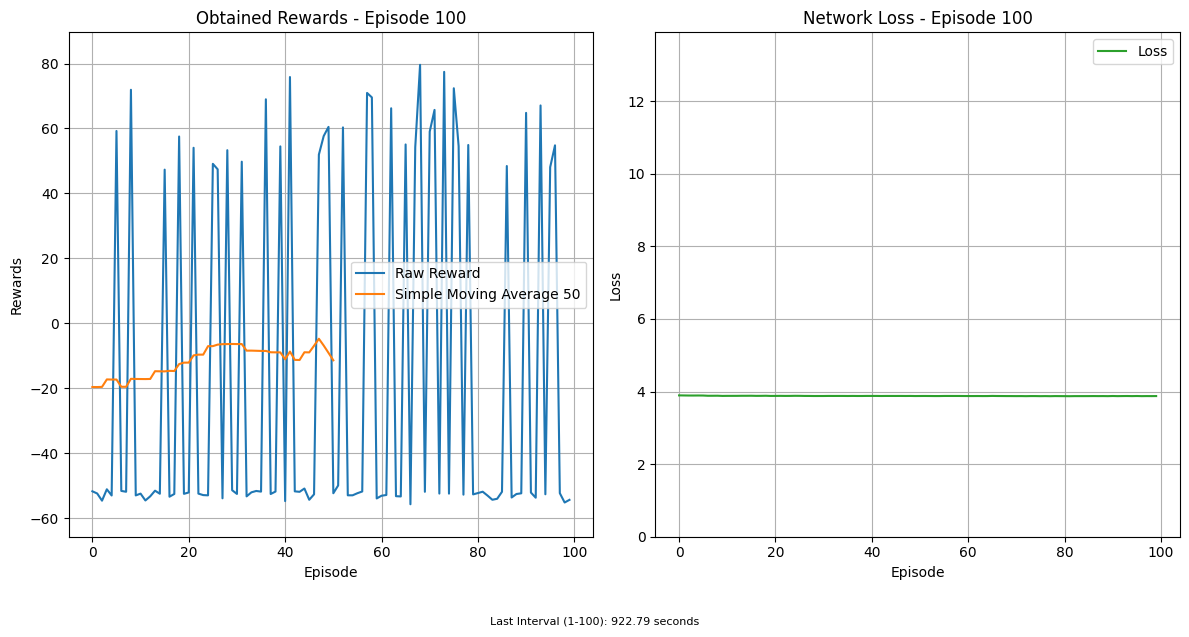

Episode 100, Total Reward: -54.408864265928244, Steps: 1000
Episode 101, Total Reward: -53.38725761772876, Steps: 1000


KeyboardInterrupt: 

In [223]:
# Set seed for reproducibility across experiments
seed = 0
set_seed(seed)

# Set up the path for saving model checkpoints
save_dir = "saved models rainbow"
os.makedirs(save_dir, exist_ok=True)  # Ensure the "saved models" directory exists

# Parameters for training or testing
train_mode = True  # Flag to toggle between training and testing modes
render = not train_mode  # If not training, render the environment
hyperparams = {
    "load_path": None,  # Path to load the pre-trained model, None during training
    "save_path": os.path.join(save_dir, "rainbow_checkpoint"),  # Path to save model checkpoints
    "save_interval": 100,  # Interval at which the model will be saved (in episodes)
    "clip_grad_norm": 5,  # Maximum gradient norm for clipping during training
    "learning_rate": 0.001,  # Learning rate for training the agent
    "discount_factor": 0.99,  # Discount factor (gamma) for future rewards
    "batch_size": 128,  # Batch size for training updates
    "update_frequency": 50,  # Number of steps before updating the target network
    "max_episodes": 1000,  # Maximum number of episodes for training
    "max_steps": 1000,  # Maximum number of steps per episode
    "memory_capacity": 250_000 if train_mode else 0,  # Replay memory capacity (only used in training)
    "num_atoms": 51,  # Number of atoms for distributional RL
    "v_min": -10,  # Minimum value for distributional support
    "v_max": 10,  # Maximum value for distributional support
    "n_step": 3,  # Number of steps for multi-step returns
    "render_fps": 60,  # Frames per second for rendering the environment
    "alpha": 0.6,  # Prioritization level for PER
    "seed": seed,  # Random seed for reproducibility
}

# Initialize the environment (MountainCarContinuous)
env = gym.make("MountainCarContinuous-v0", max_episode_steps=hyperparams["max_steps"],
               render_mode="human" if render else None)  # Set render mode based on train_mode
env.metadata["render_fps"] = hyperparams["render_fps"]

# Set seed for the environment
env.reset(seed=seed)


# Apply wrappers to the environment
env = DiscretizedActionWrapper(env, num_bins=20)  # Discretize the continuous action space
env = step_wrapper(env)  # Apply step wrapper for observation and reward modifications

# Initialize the Rainbow DQN agent with the provided hyperparameters
agent = RainbowDQN_Agent(
    env=env,
    learning_rate=hyperparams["learning_rate"],
    discount=hyperparams["discount_factor"],
    memory_capacity=hyperparams["memory_capacity"],
    seed=hyperparams["seed"],
    num_atoms=hyperparams["num_atoms"],
    v_min=hyperparams["v_min"],
    v_max=hyperparams["v_max"],
    alpha=hyperparams["alpha"],
    n_step=hyperparams["n_step"],
    clip_grad_norm=hyperparams["clip_grad_norm"]
)


# Initialize the Rainbow DQN training or testing procedure
rainbow_trainer = RainbowDQN_Train(agent=agent, env=env, hyperparams=hyperparams)

# Run the trainer in the desired mode (train or test)
if train_mode:
    rainbow_trainer.run(mode='train')  # Train the Rainbow DQN model
else:
    # Loop through checkpoints for testing
    first_model = 400  # Starting checkpoint for testing
    last_model = 500   # Ending checkpoint for testing
    for checkpoint in range(first_model, last_model, hyperparams["save_interval"]):  # Iterate through checkpoints
        checkpoint_path = os.path.join(save_dir, f"rainbow_checkpoint_{checkpoint}.pth")
        print(f"\nTesting with checkpoint: {checkpoint_path}")

        # Update the load path in hyperparameters for the current checkpoint
        hyperparams["load_path"] = checkpoint_path

        # Reinitialize the Rainbow trainer with updated hyperparameters
        rainbow_trainer = RainbowDQN_Train(agent=agent, env=env, hyperparams=hyperparams)

        # Run the test mode for the current checkpoint
        rainbow_trainer.run(mode='test', max_episodes=2)  # Test with a limited number of episodes (2)

    pygame.quit()  # Close the pygame window after testing is complete


---